# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
# code_list = sina_data.Sina().all.index.tolist()
# print(f'code_list:{len(code_list)}')
# df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')

In [3]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [4]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [5]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(10.33, '2025-03-31')

(9.66,
 54    2025-06-20
 Name: date, dtype: object)

9 -0.11 -0.97
Bear
-0.97


### regression_line(X, Y)
regression_ratio(df, window=10):

9.98 0.0
Above
0.0


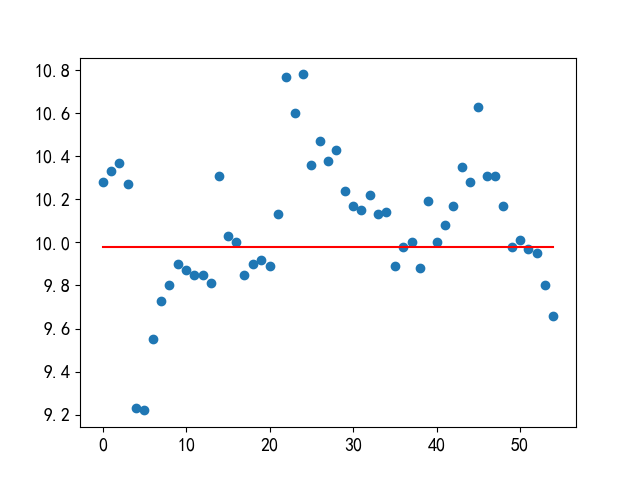

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

9.98 0.0
Above
0.0


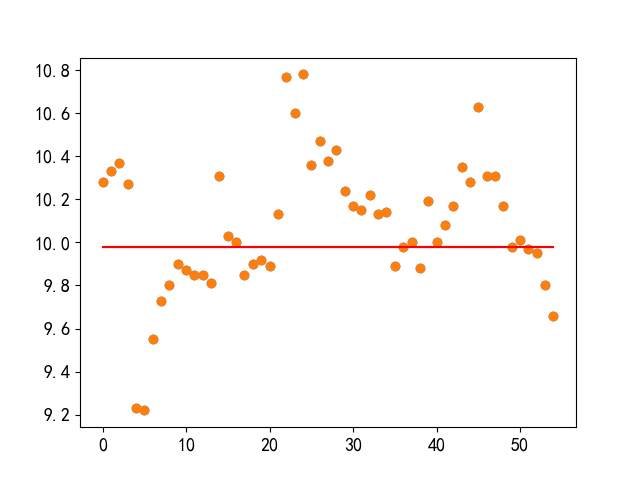

In [7]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [8]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'low4', 'lastdu4', 'macddif', 'macddea', 'macdlast1', 'macdlast2',
       'macdlast3', 'macdlast4', 'macdlast5', 'macdlast6'],
      dtype='object', length=174)

### check_postion_vol_price

In [9]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code  open  high   low  close         vol       amount  \
54  2025-06-20  601360  9.83   9.9  9.65   9.66  41581031.0  404216512.0   

    ma5d  ma10d  ...   lastdu4  macddif  macddea  macdlast1  macdlast2  \
54  9.88  10.08  ...  1.011111    -0.07     -0.0      -0.13       -0.1   

    macdlast3  macdlast4  macdlast5  macdlast6  Positon  
54      -0.08      -0.07      -0.05      -0.03  Neutral  

[1 rows x 175 columns]

In [10]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'lastdu4', 'macddif', 'macddea', 'macdlast1', 'macdlast2', 'macdlast3',
       'macdlast4', 'macdlast5', 'macdlast6', 'Positon'],
      dtype='object', length=175)

0    2025-03-31
1    2025-04-01
2    2025-04-02
Name: date, dtype: object

54   2025-06-20
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.0 
code: 601360


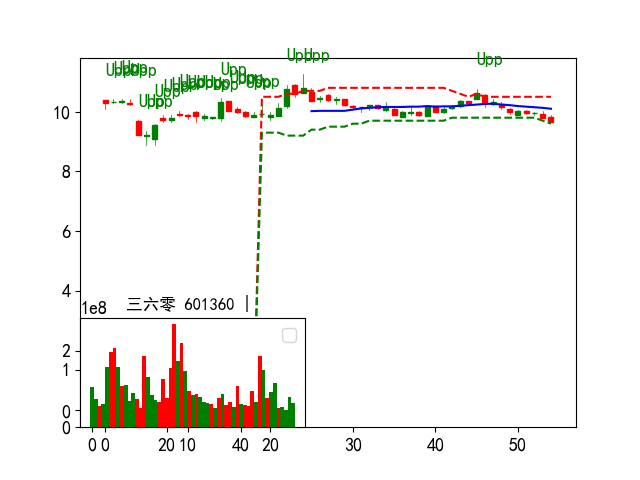

In [11]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [12]:
'code' in dfc.columns

True

### show_channel_mpl

In [13]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [14]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None,limit=20,orderby='percent'):
    col_src = [
        "name",'percent', "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if orderby in df.columns:
        df=df.sort_values('percent', ascending=False)
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name][:limit]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name][:limit]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name][:limit]
    return temp

def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [15]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.3,
        ma_250_h=1.3, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().all.index.tolist()
#     .Sina().all.index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    print(f'h5_fname:{h5_fname} h5_table:{h5_table}')
#     df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20170501', end=None, freq=None, col=None, index='date')
#     df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
#         freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)
    print(f'df:{df}')
    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [16]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.2,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5197
h5_fname:tdx_all_df_300 h5_table:all_300
df:                      open     high      low    close           vol  \
code   date                                                           
999999 2024-03-20  3058.00  3082.00  3056.00  3080.00  3.491877e+10   
       2024-03-21  3084.00  3090.00  3070.00  3078.00  3.668780e+10   
       2024-03-22  3070.00  3074.00  3028.00  3048.00  3.947405e+10   
       2024-03-25  3040.00  3066.00  3026.00  3026.00  3.874854e+10   
       2024-03-26  3026.00  3036.00  3006.00  3032.00  3.459288e+10   
...                    ...      ...      ...      ...           ...   
301091 2025-06-20    26.66    26.80    26.17    26.23  4.370710e+06   
301285 2025-06-20    29.16    29.95    29.16    29.30  1.470800e+06   
301386 2025-06-20    20.66    20.95    20.41    20.50  1.112172e+06   
300308 2025-06-20   130.00   131.12   124.75   129.50  4.930052e+07   
300101 2025-06-20    21.00    21.19    20.41    20.48  1.905900e+07   

                 

In [17]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close         vol       amount
date                                                        
2025-06-20  6.33  6.34  6.28   6.29  52448488.0  330716448.0

### Test InStock

In [18]:
df.loc['301083'][:2]

open   high    low  close        vol      amount
date                                                         
2024-03-20  15.41  15.53  15.24  15.43  6056930.0  93843040.0
2024-03-21  15.42  15.56  15.11  15.43  5771594.0  89267952.0

## ra_diff

In [19]:
tail_days = 60

In [20]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [21]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [22]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [23]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [24]:
# df.loc['000002'][-10:]

## sina_dm

In [25]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

lastb:4.5 

('2025-06-20',
 code
 601028    玉龙股份
 Name: name, dtype: object)

In [26]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-06/23/25 10:13:19'

code
300271   2025-06-23 10:13:03
002605   2025-06-23 10:13:03
Name: ticktime, dtype: datetime64[ns]

0.2757724483807882

### Combine ratio and idx

In [27]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [28]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None and store is not None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [29]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = f"{cct.get_ramdisk_dir()}\\sina_MultiIndex_data.h5".replace('\\',os.sep)
print(f'sina_MultiD_path:{sina_MultiD_path}')
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
h5code='603019'
h5.loc[h5code][-3:]
code_muti = '603019'
# h5.loc[code_muti][:2]

freq = 'D'
# freq = '5M'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
# run_col = ['close']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol = round(allvol / 10 / 1000 / 1000,2)
print("总量:%s 亿"%(allvol))
mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
#全局占比
mdf['volume'] = mdf.amount.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')
mdf.loc[h5code]

sina_MultiD_path:/Volumes/RamDisk/sina_MultiIndex_data.h5
['/all_30']
/Volumes/RamDisk/sina_MultiIndex_data.h5


(597310, 6)

close   high   low  llastp   volume  lastbuy
ticktime                                                         
2025-06-23 10:12:45  66.74  66.98  66.3    66.9  4297920    66.31
2025-06-23 10:12:51  66.66  66.98  66.3    66.9  4327320    66.75
2025-06-23 10:13:03  66.68  66.98  66.3    66.9  4340520    66.75

0.401

总量:3480.69 亿


ticktime    2025-06-24 00:00:00
close                 66.768609
volume                     0.21
vol                        4.34
amount                      2.9
Name: 603019, dtype: object

In [30]:
mdf[:2]
mdf.loc['603019']

ticktime      close  volume    vol  amount
code                                               
000001 2025-06-24  11.779652    0.38  45.29    5.34
000002 2025-06-24   6.232783    0.10  22.91    1.43

ticktime    2025-06-24 00:00:00
close                 66.768609
volume                     0.21
vol                        4.34
amount                      2.9
Name: 603019, dtype: object

In [31]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2025-06-23'

In [32]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2025-06-24 00:00:00
close                  6.232783
volume                      0.1
vol                       22.91
amount                     1.43
Name: 000002, dtype: object

###  实时成交量个股Top!!!

In [33]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [34]:
nowdf.shape,top20_nd

((5187, 5),
         volume  name
 code                
 300773    1.97   拉卡拉
 300468    1.89  四方精创
 688981    1.63  中芯国际
 300308    1.41  中际旭创
 003040    1.27   楚天龙
 601975    1.25  招商南油
 002074    1.21  国轩高科
 603799    1.21  华友钴业
 600519    1.20  贵州茅台
 300502    1.11   新易盛
 002235    1.08  安妮股份
 002104    1.07  恒宝股份
 603005    1.05  晶方科技
 300180    1.02  华峰超纤
 002384    0.98  东山精密
 002594    0.97   比亚迪
 600110    0.96  诺德股份
 002475    0.96  立讯精密
 601606    0.93  长城军工
 300429    0.91  强力新材)

In [35]:
# show_tdx_data(top20_nd)
# top20_nd.columns

### 合并实时成交量及SinaDM

In [36]:
from JSONData import tdx_hdf5_api as h5a
def get_tdx_all_from_h5(resample='d',showtable=True):
    #sina_monitor
    h5_fname = 'tdx_last_df'
    resample=resample
    if resample=='d':
        dl='60'
    else:
        dl='200'
    filter='y'
    h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    return h5


In [37]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)

In [38]:
h5tdx = get_tdx_all_from_h5(resample='w')
tdx_now_w = cct.combine_dataFrame(h5tdx,sinadm)

keys:['/low_3d_60_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [39]:
tdx_now_w.query('close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4')

lopen  lhigh   llow  lastp         lvol       lamount   ma5d  ma10d  \
code                                                                          
000407   3.22   3.23   2.76   3.04  297585984.0  1.062493e+09   3.39   3.32   
000408  27.72  27.80  26.75  27.08   27681528.0  1.130766e+09  38.38  37.12   
000519  14.86  14.93  13.39  13.40  363036768.0  6.402749e+09  16.95  16.92   
000520   4.15   4.35   4.03   4.20  720084480.0  3.880351e+09   4.95   4.73   
000554   5.68   5.89   5.52   5.59  573802496.0  4.509560e+09   6.68   6.42   
...       ...    ...    ...    ...          ...           ...    ...    ...   
870199  21.19  21.55  19.34  20.02   43460284.0  1.726262e+09  29.73  28.67   
873001  16.38  16.67  15.91  15.91   52547968.0  1.403861e+09  22.59  21.95   
873169  12.67  12.85  11.56  11.92   58539476.0  2.453713e+09  34.19  28.22   
920088  23.02  24.36  21.70  22.23   71495312.0  3.859294e+09  35.47  30.66   
920099  28.44  28.44  27.81  27.81   15969583.0  5.631818e+08  33.53  33.91   

        ma20d  ma60d  ...    b1_vv  close         nvol  lastbuy   nlow  nhigh  \
code                  ...                                                       
000407   3.28    0.0  ...  49800.0   3.59   18869000.0     3.57   3.58   3.68   
000408  34.28    0.0  ...   1600.0  40.83    1634100.0    40.75  40.62  40.94   
000519  16.02    0.0  ...  18000.0  18.24   42437101.0    18.36  18.02  18.64   
000520   4.69    0.0  ...   5800.0   5.70  109931327.0     5.76   5.56   5.89   
000554   6.10    0.0  ...   3300.0   8.01   61934422.0     8.03   7.78   8.08   
...       ...    ...  ...      ...    ...          ...      ...    ...    ...   
870199  26.38    0.0  ...   6078.0  33.99    2530624.0    34.16  32.41  34.88   
873001  21.05    0.0  ...    200.0  25.09    2751442.0    24.98  23.80  26.00   
873169  19.88    0.0  ...   5502.0  43.51    4912915.0    42.19  40.97  42.56   
920088  27.06    0.0  ...    351.0  55.60    7355209.0    56.31  55.00  59.59   
920099  31.86    0.0  ...   1000.0  34.21     871185.0    34.41  34.31  35.09   

           nclose     vol  amount  percent  
code                                        
000407   3.590901   18.87    0.68      0.3  
000408  40.811545    1.63    0.67      0.1  
000519  18.333451   42.44    7.78      3.3  
000520   5.676460  109.93    6.24      6.5  
000554   7.957611   61.93    4.93      6.5  
...           ...     ...     ...      ...  
870199  34.031000    2.53    0.86      1.0  
873001  25.052243    2.75    0.69      2.1  
873169  42.143028    4.91    2.07      8.7  
920088  56.019459    7.36    4.12      7.9  
920099  34.614660    0.87    0.30      0.1  

[206 rows x 219 columns]

### tdx_last_df and Now sina!!! RealTIME

In [40]:
tdx_h5=get_tdx_all_from_h5()
tdx_now = cct.combine_dataFrame(tdx_h5,sinadm)

keys:['/low_3d_60_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [41]:
tdx_now.shape
# tdx_now.query('close >  lastp1d  and lastl1d < ma51d and close > ma51d and lastp1d < upper and lastp1d > lastp2d and lasth1d >high4 and boll > 0 and volume < 1')
tdx_select = tdx_now.query('close > lastp1d and percent < 3')[:10]
show_tdx_data(tdx_select,limit=10)

(5402, 219)

Count:10 219


name  percent        date  close   hmax   lmin  perc1d     nclose  \
code                                                                         
000021    深科技      1.7  2025-04-08  17.08  18.27  16.86    -0.1  17.016881   
000045   深纺织Ａ      1.1  2025-04-08  10.85  11.60  10.00    -1.1  10.858962   
000017   深中华A      0.9  2025-04-08   6.42   7.28   6.31    -0.1   6.425234   
000050   深天马Ａ      0.9  2025-04-08   8.01   8.43   7.87    -0.1   8.012752   
000039   中集集团      0.8  2025-04-08   7.78   8.39   7.66     0.0   7.712252   
000004  *ST国华      0.7  2025-05-08   8.63  10.38   7.56    -1.1   8.528298   
000025   特 力Ａ      0.7  2025-04-08  16.95  18.56  16.77    -0.1  16.931101   
000049   德赛电池      0.6  2025-04-08  21.71  21.73  20.91     0.1  21.676055   
000020   深华发Ａ      0.5  2025-04-08  13.72  13.78  11.72    -1.1  13.657719   
000032   深桑达Ａ      0.2  2025-06-20  18.51  22.53  19.00    -0.1  18.531019   

         llow  perc3d  perc5d  
code                           
000021  15.12     0.1     0.2  
000045   9.02     0.1    -0.1  
000017   5.35    -1.1     0.0  
000050   6.93     1.2     0.0  
000039   7.23     0.0     1.2  
000004   7.37    -1.1     0.0  
000025  14.73    -0.1     0.1  
000049  19.17     1.3     0.0  
000020   9.85    27.3     0.0  
000032  18.45    -0.1     0.1

In [42]:
tdx_now.query('close.isna()').buy
# tdx_h5.loc['301397']
tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("688")')

show_tdx_data(tdx_filter)

code
399001   NaN
399005   NaN
999999   NaN
399006   NaN
300311   NaN
          ..
688721   NaN
688726   NaN
688750   NaN
688757   NaN
688758   NaN
Name: buy, Length: 228, dtype: float64

Count:28 219


name  percent        date  close   hmax   lmin  perc1d     nclose  \
code                                                                        
300072  海新能科     18.4  2025-04-07   3.66   3.21   2.96   -1.00   3.540789   
300531   优博讯     18.2  2025-04-07  20.83  18.44  15.23   -1.10  20.713421   
300172  中电环保     14.6  2025-04-07   6.21   5.68   4.91   -1.10   5.748246   
600844  丹化科技     10.1  2025-03-31   3.60   3.42   3.04   -1.10   3.581339   
002213  大为股份     10.0  2025-04-08  19.14  16.48  13.62   -1.10  18.605614   
003026  中晶科技     10.0  2025-04-08  34.38  33.78  30.20   -1.10  33.497965   
300541  先进数通      9.9  2025-04-07  15.37  15.13  12.93   -1.10  14.743158   
603373  安邦护卫      6.8  2025-04-07  45.70  42.81  30.00    0.00  44.939099   
300772  运达股份      6.7  2025-04-07  12.82  12.72  10.31   -1.10  12.524696   
300698  万马科技      6.6  2025-04-07  43.50  42.19  33.66   -0.10  42.853565   
603255   鼎际得      6.1  2025-04-28  28.89  26.38  24.41   -1.10  27.992072   
002074  国轩高科      6.1  2025-04-08  27.45  26.66  21.09   -1.10  27.116460   
002443  金洲管道      5.0  2025-04-07   6.57   6.41   5.80   -1.10   6.528649   
003015  日久光电      4.9  2025-04-09  15.81  15.39  13.75    0.10  15.942566   
301238  瑞泰新材      4.0  2025-04-07  18.72  18.20  16.70    1.30  18.577281   
300046  台基股份      4.0  2025-04-07  34.95  32.44  29.38   25.91  35.056228   
000698  沈阳化工      3.9  2025-04-08   4.02   3.95   3.61   -0.90   4.008125   
601615  明阳智能      3.7  2025-04-08  11.06  10.69   9.83    0.00  10.850625   
603375   盛景微      2.3  2025-04-08  36.60  35.66  33.81    1.20  36.838532   
603867  新化股份      2.3  2025-04-07  25.70  25.45  23.55    1.30  25.761560   

         llow  perc3d  perc5d  
code                           
300072   2.53     1.3    0.00  
300531  10.77     1.2    0.10  
300172   4.27     1.2   -0.90  
600844   2.65    23.0    0.10  
002213  11.82    22.3    0.00  
003026  24.20     0.1    1.20  
300541  10.29     0.0   20.30  
603373  26.59     0.1   13.20  
300772   9.51     0.0   40.31  
300698  30.31     0.1    0.00  
603255  21.33    30.3    1.30  
002074  18.91     0.1    0.00  
002443   5.28     0.1    0.20  
003015  11.27     1.2   26.41  
301238  14.33     0.0    0.00  
300046  23.91     0.1    1.30  
000698   2.92    -0.1    0.10  
601615   9.36     1.3    1.30  
603375  29.88     0.1    0.00  
603867  22.98    -1.1    0.10

#### 新高test!!!!!!

In [43]:
# write_code_to_blk(tdx_filter.index.tolist(),'rqg')

In [44]:
sinadm.shape
sinadm.columns
# sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)
# sinadm['percent'] = sinadm['percent'].round(1)
sinadm.query('percent > 6 ')

(5176, 43)

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol',
       'lastbuy', 'nlow', 'nhigh', 'nclose', 'vol', 'amount', 'percent'],
      dtype='object')

name   open  llastp    now  trade   high    low    buy   sell  \
code                                                                     
300164   通源石油   7.78    7.19   7.83    0.0   8.30   7.60   7.82   7.83   
688203   海正生材  13.00   13.06  13.91    0.0  14.79  12.87  13.90  13.91   
603155    新亚强  15.07   14.39  15.83    0.0  15.83  14.71  15.83   0.00   
688230   芯导科技  48.68   48.68  53.74    0.0  54.97  48.30  53.73  53.74   
002040  南 京 港  11.41   10.64  11.70    0.0  11.70  11.41  11.70   0.00   
...       ...    ...     ...    ...    ...    ...    ...    ...    ...   
300618   寒锐钴业  34.55   32.77  36.51    0.0  37.49  34.41  36.49  36.50   
688371    菲沃泰  14.90   14.97  15.92    0.0  16.05  14.78  15.92  15.93   
002537   海联金汇   8.81    8.61   9.47    0.0   9.47   8.81   9.47   0.00   
300072   海新能科   3.16    3.09   3.66    0.0   3.70   3.16   3.66   3.67   
003029   吉大正元  24.31   23.78  26.16    0.0  26.16  24.31  26.16   0.00   

           volume  ...     b1_vv  close       nvol  lastbuy   nlow  nhigh  \
code               ...                                                      
300164  151526918  ...     44700   7.83  151526918     7.83   7.69   8.30   
688203    6740121  ...      3370  13.91    6740121    14.52  12.87  14.10   
603155   16583182  ...  10242072  15.83   16583182    15.83  14.71  15.77   
688230    2106852  ...       200  53.74    2106852    52.25  48.31  52.53   
002040   45208753  ...   8266400  11.70   45208753    11.70  11.41  11.70   
...           ...  ...       ...    ...        ...      ...    ...    ...   
300618   21598289  ...      7700  36.51   21598289    36.97  34.41  36.47   
688371    2688900  ...      1635  15.92    2688900    15.55  14.78  15.46   
002537   87108116  ...  92991600   9.47   87108116     9.47   8.81   9.47   
300072   98712886  ...    172800   3.66   98712886     3.62   3.16   3.60   
003029   13087600  ...   9780700  26.16   13087600    26.16  24.31  26.16   

           nclose     vol  amount  percent  
code                                        
300164   7.865263  151.53   11.92      8.9  
688203  13.914091    6.74    0.94      6.5  
603155  15.595185   16.58    2.59     10.0  
688230  52.268972    2.11    1.10     10.4  
002040  11.696875   45.21    5.29     10.0  
...           ...     ...     ...      ...  
300618  36.279043   21.60    7.84     11.4  
688371  15.506893    2.69    0.42      6.3  
002537   9.456637   87.11    8.24     10.0  
300072   3.540789   98.71    3.50     18.4  
003029  26.134727   13.09    3.42     10.0  

[85 rows x 43 columns]

## check HDF LastDate

In [45]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

#今日的code
df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape

#没有今日的code
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4924, 7)

In [46]:
# df_tail1

In [47]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open    high     low   close          vol        amount  \
code   date                                                                    
999999 2025-06-20  3358.0  3370.0  3358.0  3360.0  350223648.0  4.108733e+11   

                   ra_diff  
code   date                 
999999 2025-06-20     1.09

In [48]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [49]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [50]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [51]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [52]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2025-06-19   8.47   8.67  8.45  8.51
2025-06-20   8.47   8.66  8.44  8.50

Empty DataFrame
Columns: [open, high, low, close, vol, amount, ra_diff, ma10, ma5, ma20, ma250, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d]
Index: []

[0 rows x 28 columns]

(60, 28)


In [53]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff     hat   close  volsum5d    hmax    lmin  perc1d    ma20  \
date                                                                            
2025-06-19      1.0  216.38  1426.0      20.0  1596.0  1401.0    0.07  1501.7   
2025-06-20      1.0  212.14  1429.0     -29.2  1588.0  1401.0    0.21  1494.1   

             ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d   ma51d  \
date                                                                            
2025-06-19  379.45 -20.35  12.96 -36.51 -27.45  91.35    0.28   -3.65  1425.4   
2025-06-20  385.11  42.10 -20.35  12.96 -36.51 -27.45    0.14    0.14  1425.8   

            ra_diff  
date                 
2025-06-19      1.0  
2025-06-20      1.0

### Append Now SinaTo MultiIndex dfNow

In [54]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

concat1 init:sina_today:688178
concat1:sina_today:688178 2025-06-23 00:00:00


open   high    low  close           vol        amount  \
code   date                                                                 
000001 2025-06-20  11.70  11.86  11.67  11.84  1.309198e+08  1.544542e+09   
       2025-06-23  11.81  11.85  11.67  11.78  4.529000e+01  5.340000e+00   

                   ra_diff   ma10    ma5   ma20  ...  perc4d  perc5d   vol1d  \
code   date                                      ...                           
000001 2025-06-20     1.11  11.75  11.77  11.67  ...    0.34    2.07   57.31   
       2025-06-23      NaN  11.76  11.77  11.68  ...    0.17   -0.17 -100.00   

                   vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  name  
code   date                                                           
000001 2025-06-20  21.76 -23.20 -24.22   7.21      38.9  11.77   NaN  
       2025-06-23  57.31  21.76 -23.20 -24.22     -68.3    NaN  平安银行  

[2 rows x 30 columns]

In [55]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close    vol  amount  ra_diff  ma10  ma5  ma20  \
date                                                                           
2025-06-23  6.26  6.27  6.21   6.24  22.91    1.43      NaN   NaN  NaN   NaN   

            ...  perc4d  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  \
date        ...                                                                
2025-06-23  ...     NaN     NaN    NaN    NaN    NaN    NaN    NaN       NaN   

            ma51d  name  
date                     
2025-06-23    NaN  万 科Ａ  

[1 rows x 30 columns]

### Xratio and tail 60 MultiIndex 

In [56]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [57]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                       
2025-03-07  73.5  73.94  71.62  72.06  37972536.0  2.763343e+09     1.21   

             ma10   ma5   ma20  ...  perc4d  perc5d    vol1d  vol2d  vol3d  \
date                            ...                                          
2025-03-07  15.26  21.6  12.09  ...  691.87  709.66  1161.63 -55.31   27.7   

            vol4d   vol5d  volsum5d  ma51d  name  
date                                              
2025-03-07  -39.5  159.84    1254.4   21.6   NaN  

[1 rows x 30 columns]

## DFNow Query check

In [58]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-06-20


code    date      
301325  2025-06-20    0.19
301292  2025-06-20    0.16
301152  2025-06-20    0.11
603255  2025-06-20    0.09
603928  2025-06-20    0.09
300619  2025-06-20    0.07
301308  2025-06-20    0.06
301041  2025-06-20    0.06
002986  2025-06-20    0.05
300739  2025-06-20    0.05
Name: xratio, dtype: float64

date
2025-06-11     NaN
2025-06-13   -0.04
2025-06-16   -0.06
2025-06-17   -0.08
2025-06-18   -0.09
2025-06-19   -0.11
2025-06-20   -0.12
2025-06-23   -0.11
Name: close, dtype: float64

In [59]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2025-06-20    5.75
2025-06-23     NaN
Name: upper, dtype: float64

(60, 30)
xratio:-0.0 ra_diff:nan
code: 300459


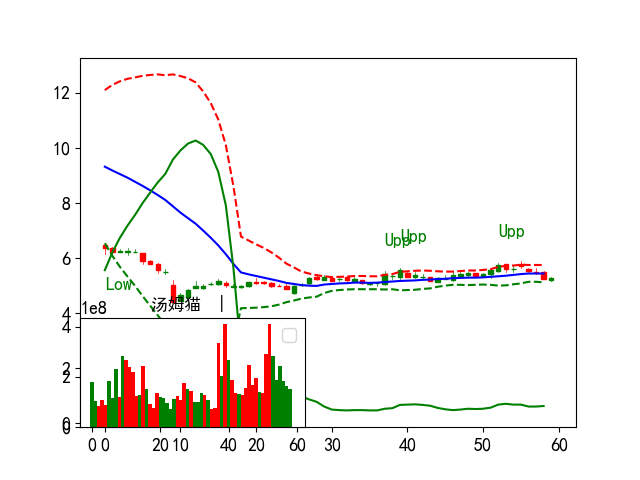

In [60]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

In [61]:
# '302132' in dfsRoot.index

300773
xratio:0.17 ra_diff:nan
code: 300773


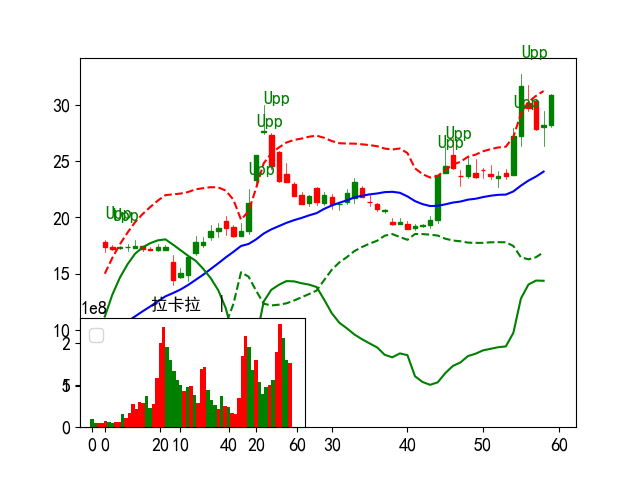

300468
xratio:0.3 ra_diff:nan
code: 300468


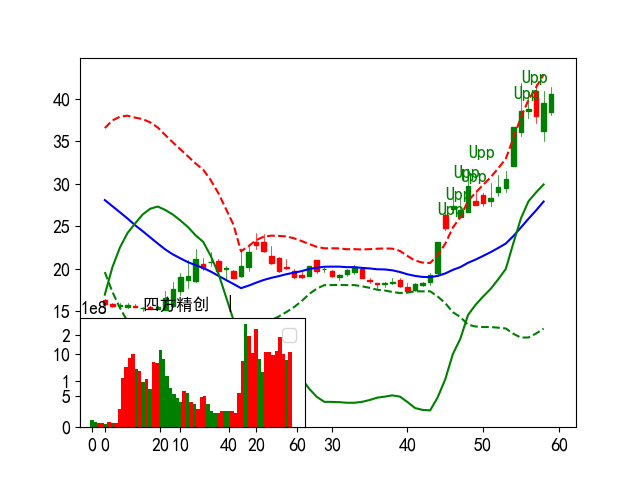

In [62]:
for co in top20_nd.index[:2]:
    print(co)
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    if co in dfsRoot.index:
        show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)
    else:
        print(f'code:{co} not find in dfsRoot')

In [63]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date   open   high   low  close    vol  amount  ra_diff   ma10  \
code                                                                          
688981 2025-06-23  81.03  85.30  80.9  84.52  27.29   22.75      NaN  82.72   
688800 2025-06-23  46.00  47.18  45.8  46.59   3.70    1.73      NaN  45.88   

          ma5  ...  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  name  \
code           ...                                                             
688981  82.35  ... -100.0  -5.85  18.89   8.34  10.03     -68.6    NaN  中芯国际   
688800  46.36  ... -100.0 -50.98  52.68  85.61 -37.40     -50.1    NaN   瑞可达   

        xratio   idx  
code                  
688981   -0.08  0.08  
688800   -0.37 -0.63  

[2 rows x 33 columns]

In [64]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [65]:
df.loc['000002'][-2:]

open  high   low  close         vol       amount  ra_diff
date                                                                 
2025-06-19  6.42  6.43  6.30   6.32  85454624.0  542431808.0      1.0
2025-06-20  6.33  6.34  6.28   6.29  52448488.0  330716448.0      1.0

In [66]:
dfNow.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff  ma10  \
date                                                                            
2025-06-20  6.33  6.34  6.28   6.29  52448488.00  3.307164e+08      1.0  6.50   
2025-06-23  6.26  6.27  6.21   6.24        22.91  1.430000e+00      NaN  6.46   

             ma5  ma20  ...   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  \
date                    ...                                                 
2025-06-20  6.44  6.57  ...  -38.62  34.49   9.10 -55.28  48.64      -1.7   
2025-06-23  6.36  6.55  ... -100.00 -38.62  34.49   9.10 -55.28    -150.3   

            ma51d  name  xratio   idx  
date                                   
2025-06-20   6.44   NaN   -0.02 -0.31  
2025-06-23    NaN  万 科Ａ   -0.02 -0.38  

[2 rows x 32 columns]

# 基础处理

In [67]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-05-27 2025-06-20


open   high    low  close           vol        amount  \
code   date                                                                 
000001 2025-06-20  11.70  11.86  11.67  11.84  1.309198e+08  1.544542e+09   
       2025-06-23  11.81  11.85  11.67  11.78  4.529000e+01  5.340000e+00   

                   ra_diff   ma10    ma5   ma20  ...   vol1d  vol2d  vol3d  \
code   date                                      ...                         
000001 2025-06-20     1.11  11.75  11.77  11.67  ...   57.31  21.76 -23.20   
       2025-06-23     0.00  11.76  11.77  11.68  ... -100.00  57.31  21.76   

                   vol4d  vol5d  volsum5d  ma51d  name  xratio   idx  
code   date                                                           
000001 2025-06-20 -24.22   7.21      38.9  11.77     0    0.02  0.14  
       2025-06-23 -23.20 -24.22     -68.3   0.00  平安银行    0.02  0.07  

[2 rows x 32 columns]

Low:2025-05-27


Timestamp('2025-05-27 00:00:00')

In [68]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
  #      top_temp = top_temp[(~top_temp.index.str.contains(
  #          '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(9947, 32)
count dd.couts
(code    date      
688668  2025-05-27    17
603373  2025-05-27    17
601009  2025-05-27    17
301369  2025-05-27    17
301345  2025-05-27    17
Name: couts, dtype: int64, (9947, 33))
dt_low:2025-05-27 df:267 Index(['688668', '603373', '601009', '301369', '301345'], dtype='object', name='code') df_idx:749
Main Down dd :29 MainUP df:267 couts std:4.3 
time: 0.2  216


In [69]:
dfs_dtlen.loc['002987'][-1:]

open   high   low  close    vol  amount  ra_diff   ma10    ma5  \
date                                                                         
2025-06-23  14.8  15.42  14.6  15.31  31.33    4.77      0.0  14.65  15.01   

             ma20  ...  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  \
date               ...                                                       
2025-06-23  14.15  ... -100.0 -25.97 -11.08   6.92   9.66    -120.5    0.0   

            name  xratio   idx  
date                            
2025-06-23   京北方    0.13  0.69  

[1 rows x 32 columns]

## 最近60天筛选

In [70]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [71]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(df_mask250)

(898, 32)
count dd.couts
(code    date      
002983  2025-05-09    15
Name: couts, dtype: int64, (898, 33))
(code    date      
002983  2025-06-19    15
600000  2025-06-20    14
Name: couts, dtype: int64, (280, 33))
Count:280 33


name  couts  ra_diff  xratio   idx    hat  close  volsum5d  \
code   date                                                                    
688313 2025-05-19    0      2     2.25    0.00  0.00  19.88  31.09       3.6   
300871 2025-05-22    0      3     2.00    0.00  0.00   6.42  24.52       7.4   
603665 2025-06-11    0      5     1.83    0.00  0.00   7.81  26.05     109.2   
002549 2025-06-03    0      3     1.71    0.00  0.00   2.63  10.42       8.8   
300740 2025-05-28    0      1     1.69    0.00  0.00   4.50  16.91     191.2   
300095 2025-06-10    0      2     1.64    0.00  0.00   1.70   9.30     268.2   
603906 2025-06-19    0      2     1.62    0.18  1.25   5.00  14.48     -58.0   
002734 2025-05-23    0      1     1.62    0.00  0.00   3.51  15.93      97.3   
603123 2025-05-30    0      1     1.62    0.00  0.00   2.60  11.25     234.5   
603680 2025-06-16    0      2     1.60    0.12  1.10   4.24  11.50      64.3   
600415 2025-06-19    0      7     1.60    0.14  1.03   4.08  19.47     148.3   
300947 2025-06-18    0      3     1.59    0.06  0.41   3.75  22.55      46.9   
003005 2025-05-20    0      8     1.59    0.00  0.00   2.77  29.92     -26.0   
300703 2025-05-26    0      2     1.58    0.00  0.00   4.73  17.48     207.6   
300542 2025-06-18    0      2     1.56    0.11  1.84   3.78  21.67      72.2   
603586 2025-06-11    0      1     1.56    0.00  0.00   1.52  19.09      46.0   
002537 2025-06-06    0      1     1.55    0.00  0.00   2.96   8.02     693.7   
688621 2025-06-04    0      2     1.54    0.00  0.00  17.83  57.09      25.6   
301013 2025-05-28    0      2     1.53    0.00  0.00   4.67  19.80      89.2   
688379 2025-05-27    0      9     1.52    0.00  0.00   8.47  29.42     126.0   

                    hmax   lmin  perc1d   ma20  ma250   vol1d  vol2d   vol3d  \
code   date                                                                    
688313 2025-05-19  33.28  14.91   -1.24  29.98  29.78  -17.23  39.23  -34.07   
300871 2025-05-22  28.19  20.72   -9.35  22.68  22.61  -22.08 -10.15  100.02   
603665 2025-06-11  27.98  19.48    5.98  24.11  24.83   -7.65  25.62   83.38   
002549 2025-06-03  11.62   8.42    2.16   9.74   9.50  -20.67 -16.71  -29.49   
300740 2025-05-28  16.91  11.64   20.01  15.62  16.16  171.08  49.57  -42.71   
300095 2025-06-10  10.40   8.21   -2.62   8.79   8.47  -25.83  -8.46  325.56   
603906 2025-06-19  16.11  11.14    0.28  13.31  13.51   -7.97 -18.43   41.26   
002734 2025-05-23  16.00  12.14    4.80  15.09  15.05   37.28  -0.10  -29.97   
603123 2025-05-30  11.25   7.86    9.97  10.41  10.45   48.75  68.70  -31.63   
603680 2025-06-16  14.00   9.66    0.00  10.78  10.62  -20.78 -60.68   -6.50   
600415 2025-06-19  20.12  16.70   -1.57  18.17  18.01  -39.52  95.91    8.29   
300947 2025-06-18  24.38  19.69   -3.47  21.69  20.76   -8.35 -14.05    9.88   
003005 2025-05-20  31.98  28.77    0.37  28.92  28.61  -15.60 -12.62  -37.52   
300703 2025-05-26  19.94  13.83    2.10  16.40  16.18   14.73 -22.14  -39.52   
300542 2025-06-18  22.41  18.20   -1.77  20.12  20.34  -34.70  33.68   27.70   
603586 2025-06-11  19.09  17.09   10.09  17.85  18.32   27.51   5.36   36.47   
002537 2025-06-06   9.16   6.53   -7.82   7.40   7.49  -21.34  -2.46   32.82   
688621 2025-06-04  59.97  41.91   -1.57  52.26  54.41  -25.07 -14.53   43.84   
301013 2025-05-28  21.14  14.10    6.34  19.74  18.20   68.49  98.41  -40.98   
688379 2025-05-27  32.16  22.84   -2.13  27.90  27.06  -26.28 -23.85   22.21   

                    vol4d   vol5d  perc3d  perc5d  
code   date                                        
688313 2025-05-19   39.92  -24.20    4.72    7.28  
300871 2025-05-22  -33.46  -26.96    4.25   -2.54  
603665 2025-06-11   -3.54   11.39    0.27    1.09  
002549 2025-06-03  101.89  -26.25   -3.96    1.56  
300740 2025-05-28  -23.24   36.49   24.98   16.78  
300095 2025-06-10    6.90  -29.94   11.38    9.80  
603906 2025-06-19  -30.75  -42.09    0.56   -1.76  
002734 2025-05-23   29.09   

limit_output extension: Maximum message size of 10000 exceeded with 10927 characters

#### filter today

In [72]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [73]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [74]:
dfs.loc['301073'][-5:].ra_diff

date
2025-06-17    1.13
2025-06-18    1.16
2025-06-19    1.16
2025-06-20    1.18
2025-06-23    0.00
Name: ra_diff, dtype: float64

xratio:-0.01 ra_diff:nan
code: 000002


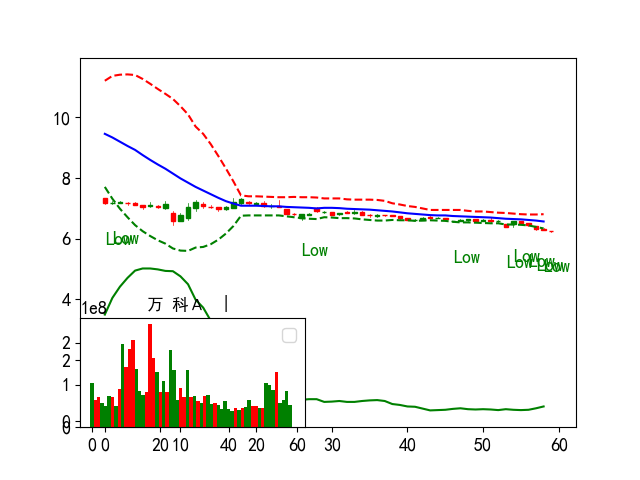

In [75]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [76]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [77]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-06-18    1.09
        2025-06-19    1.09
        2025-06-20    1.09
399001  2025-06-18    1.09
        2025-06-19    1.07
        2025-06-20    1.07
399006  2025-06-18    1.14
        2025-06-19    1.12
        2025-06-20    1.11
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [78]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 32


name  ra_diff  xratio  idx   hat  close      volsum5d   hmax  \
date                                                                      
2025-05-09    0     1.16     0.0  0.0  2.34  17.73  1.850858e+09  18.50   
2025-05-12    0     1.18     0.0  0.0  2.58  18.09  1.850858e+09  18.50   
2025-05-13    0     1.15     0.0  0.0  2.62  17.62  1.850858e+09  18.50   
2025-05-14    0     1.14     0.0  0.0  2.64  17.45  1.850858e+09  18.50   
2025-05-15    0     1.12     0.0  0.0  2.62  17.05  1.850858e+09  18.50   
2025-05-16    0     1.12     0.0  0.0  2.58  17.11 -9.420000e+01  18.50   
2025-05-19    0     1.12     0.0  0.0  2.40  17.09 -1.054000e+02  18.50   
2025-05-20    0     1.12     0.0  0.0  2.20  17.08 -5.270000e+01  18.50   
2025-05-21    0     1.10     0.0  0.0  2.06  16.84  2.080000e+01  18.50   
2025-05-22    0     1.09     0.0  0.0  2.06  16.62 -2.600000e+00  18.50   
2025-05-23    0     1.08     0.0  0.0  2.06  16.44  3.910000e+01  18.50   
2025-05-26    0     1.09     0.0  0.0  2.08  16.62  8.800000e+00  18.50   
2025-05-27    0     1.10     0.0  0.0  2.06  16.88  6.630000e+01  18.50   
2025-05-28    0     1.09     0.0  0.0  2.08  16.69 -1.140000e+01  18.50   
2025-05-29    0     1.12     0.0  0.0  1.88  17.09  2.267000e+02  18.50   
2025-05-30    0     1.12     0.0  0.0  1.75  17.14  2.030000e+02  18.50   
2025-06-03    0     1.12     0.0  0.0  1.65  17.19  2.239000e+02  18.50   
2025-06-04    0     1.13     0.0  0.0  1.65  17.30  1.668000e+02  18.50   
2025-06-05    0     1.19     0.0  0.0  1.90  18.17  3.423000e+02  18.50   
2025-06-06    0     1.18     0.0  0.0  1.98  17.98  1.050000e+02  18.59   

             lmin  perc1d   ma20  ma250         vol1d         vol2d  \
date                                                                  
2025-05-09  14.39   48.74  12.15  12.80  1.850858e+09 -1.000000e+02   
2025-05-12  15.70    2.03  12.49  12.82  3.710000e+00  1.850858e+09   
2025-05-13  15.70   -2.60  12.80  12.83 -3.593000e+01  3.710000e+00   
2025-05-14  15.70   -0.96  13.09  12.85 -3.436000e+01 -3.593000e+01   
2025-05-15  15.70   -2.29  13.37  12.86 -1.680000e+00 -3.436000e+01   
2025-05-16  15.70    0.35  13.65  12.88 -2.597000e+01 -1.680000e+00   
2025-05-19  15.70   -0.12  13.93  12.89 -7.420000e+00 -2.597000e+01   
2025-05-20  15.99   -0.06  14.19  12.91  1.672000e+01 -7.420000e+00   
2025-05-21  15.99   -1.41  14.45  12.93  3.919000e+01  1.672000e+01   
2025-05-22  15.99   -1.31  14.68  12.94 -2.510000e+01  3.919000e+01   
2025-05-23  15.99   -1.08  14.90  12.95  1.576000e+01 -2.510000e+01   
2025-05-26  15.99    1.09  15.13  12.96 -3.773000e+01  1.576000e+01   
2025-05-27  15.99    1.56  15.37  12.98  7.420000e+01 -3.773000e+01   
2025-05-28  15.99   -1.13  15.58  12.99 -3.856000e+01  7.420000e+01   
2025-05-29  15.99    2.40  15.83  13.01  2.130100e+02 -3.856000e+01   
2025-05-30  16.23    0.29  16.08  13.02 -7.930000e+00  2.130100e+02   
2025-06-03  16.39    0.29  16.33  13.04 -1.683000e+01 -7.930000e+00   
2025-06-04  16.39    0.64  16.59  13.05  1.711000e+01 -1.683000e+01   
2025-06-05  16.39    5.03  16.91  13.07  1.369000e+02  1.711000e+01   
2025-06-06  16.39   -1.05  17.21  13.08 -2.424000e+01  1.369000e+02   

                   vol3d         vol4d         vol5d  perc3d  perc5d  
date                                                                  
2025-05-09 -3.623000e+01  8.274000e+01 -2.414000e+01   48.12   45.45  
2025-05-12 -1.000000e+02 -3.623000e+01  8.274000e+01   51.89   48.52  
2025-05-13  1.850858e+09 -1.000000e+02 -3.623000e+01   47.82   47.20  
2025-05-14  3.710000e+00  1.850858e+09 -1.000000e+02   -1.58   46.52  
2025-05-15 -3.593000e+01  3.710000e+00  1.850858e+09   -5.75   43.04  
2025-05-16 -3.436000e+01 -3.593000e+01  3.710000e+00   -2.89   -3.50  
2025-05-19 -1.680000e+00 -3.436000e+01 -3.593000e+01   -2.06   -5.53  
2025-05-20 -2.597000e+01 -1.680000e+00 -3.436000e+01    0.18   -3.06  
2025-05-21 -7.420000e+00 -2.597000e+01 -1.680000e+00   -1.58   -3.50  
2025-05-22  1.67

limit_output extension: Maximum message size of 10000 exceeded with 10705 characters

## !!! Run-Filter强势Upper

### !!! filterRule test

In [79]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 -0.01 -0.12


'Bear'

-0.12

date
2025-06-17   -0.0
2025-06-18   -0.0
2025-06-19   -0.0
2025-06-20   -0.0
2025-06-23   -0.0
Name: xratio, dtype: float64

xratio:0.0 ra_diff:nan
code: 601728


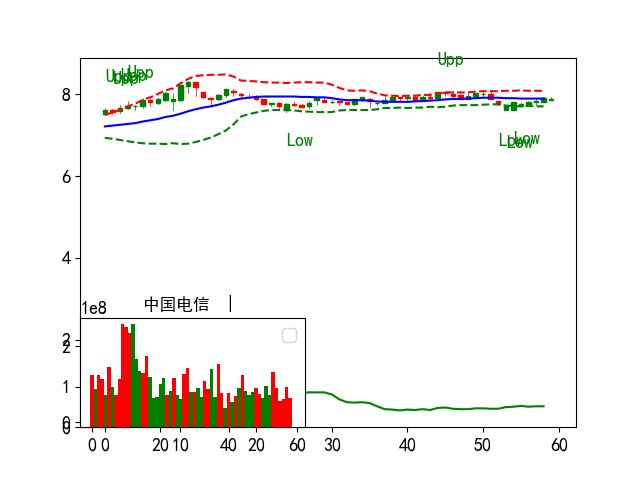

In [80]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [81]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

30
xratio:0.02 ra_diff:nan
code: 600012


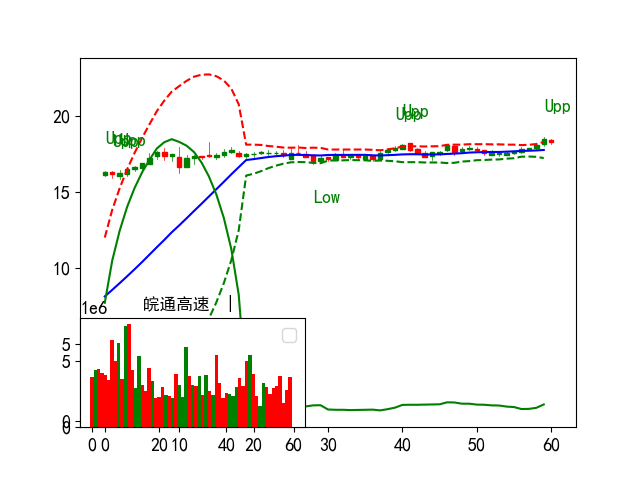

In [82]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [83]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 601009    16
 Name: couts, dtype: int64,
 (453, 41))

Count:453 41


name  couts       date  perc  ra_diff  xratio    idx    hat   close  \
code                                                                           
601009  XD南京银     16 2025-06-20 -0.59     1.19    0.06   0.76   1.50   11.78   
600919   江苏银行     16 2025-06-23 -0.34     0.00    0.05   0.62   0.00   11.84   
600000   浦发银行     15 2025-06-23  0.31     0.00    0.03   0.75   0.00   13.06   
600926   杭州银行     12 2025-06-23 -0.58     0.00    0.07   0.52   0.00   17.05   
300308   中际旭创     11 2025-06-20 -1.25     1.80    1.57  26.06  53.85  127.88   
002940    昂利康     11 2025-06-20 -2.32     2.58    0.83  12.32  25.34   31.20   
301097   天益医疗     10 2025-06-23  3.64     0.00    0.03  -0.62   0.00   38.69   
603209   兴通股份      9 2025-06-23  9.98     0.00    0.07   3.05   0.00   18.07   
002270   华明装备      9 2025-06-23 -1.66     0.00    0.08   1.77   0.00   17.23   
002352   顺丰控股      9 2025-06-20 -1.54     1.26    0.25   3.75   6.57   49.87   
002741   光华科技      9 2025-06-23  3.45     0.00    0.20   2.31   0.00   20.08   
300093  *ST金刚      9 2025-06-23  1.13     0.00    0.16   0.74   0.00   13.37   
600036   招商银行      9 2025-06-20 -0.46     1.14    0.10   1.53   3.50   45.78   
002558   巨人网络      9 2025-06-23 -0.24     0.00    0.35   5.05   0.00   21.14   
002057   中钢天源      8 2025-06-20 -0.45     1.25    0.03   0.55   1.04    8.80   
600673    东阳光      8 2025-06-20 -2.33     1.31    0.08   1.45   3.04   11.33   
603306  XD华懋科      8 2025-06-23  1.12     0.00    0.33   4.25   0.00   44.25   
603799   华友钴业      8 2025-06-23  6.44     0.00    0.08   3.48   0.00   37.86   
603373   安邦护卫      8 2025-06-23  6.83     0.00    0.53   7.17   0.00   45.70   
301132   满坤科技      7 2025-06-20 -1.14     1.61    0.15   5.41   7.34   33.02   

        volsum5d  ...  ma250      nclose    llow   vol1d   vol2d   vol3d  \
code              ...                                                      
601009      11.9  ...   7.65   11.805133   11.82   43.57  -17.17    9.77   
600919     -20.7  ...   0.00   11.840179   11.74 -100.00   72.38   30.18   
600000     -17.8  ...   0.00   13.041842   12.88 -100.00   59.46  -37.34   
600926      -8.6  ...   0.00   17.067321   16.91 -100.00   44.09   24.03   
300308      45.7  ...  28.84  128.080957  124.75  -21.21   -7.74   89.33   
002940     -40.1  ...  17.00   30.949115   27.06  -24.00  -27.09  -18.70   
301097    -128.1  ...   0.00   38.832979   38.19 -100.00  -26.49    9.81   
603209     344.8  ...   0.00   18.060000   18.07 -100.00  328.44    1.96   
002270      85.7  ...   0.00   17.441182   17.23 -100.00    6.37   31.59   
002352      45.1  ...  21.97   49.833246   49.44   52.59    8.30   -5.30   
002741      16.2  ...   0.00   20.162632   19.05 -100.00   50.54   27.80   
300093       3.6  ...   0.00   13.457748   13.00 -100.00   17.29   22.38   
600036      -0.6  ...  23.44   45.749107   45.56  -12.72   20.41  -10.08   
002558    -126.2  ...   0.00   21.662124   20.85 -100.00  -11.36    6.43   
002057     163.6  ...   6.71    8.807768    8.55  236.16  -14.01   -1.63   
600673      29.3  ...   8.41   11.358919   11.46   -3.12  -14.21    0.64   
603306      24.4  ...   0.00   44.320991   43.00 -100.00  -49.21  -13.82   
603799       4.0  ...   0.00   37.801491   36.98 -100.00  -23.67   28.66   
603373    -172.0  ...   0.00   44.939099   42.80 -100.00  -20.43    0.12   
301132     863.4  ...  22.03   33.475439   31.66   11.34   44.37  842.67   

         vol4d   vol5d  perc3d  perc5d  
code                                    
601009  -14.74   -9.50    2.64    2.99  
600919  -22.90   -0.38    0.85    1.20  
600000   86.93  -26.85    2.19    3.65  
600926  -22.74   45.99    2.96    2.77  
300308  -39.66   25.02    8.48   11.04  
002940   35.48   -5.74   10.06   21.44  
301097   19.28  -30.75    0.65   -0.79  
603209  -23.51  137.90   19.04   21.28  
002270  -21.70  169.44   -1.03    6.36  
002352  -27.71   17.23    1.95    3.39  
002741  -33.22   71.05    9.73   11.56  
300093   80.68  -16.79    7.82   13.31  
6

limit_output extension: Maximum message size of 10000 exceeded with 10950 characters

#### !!! hmax Top upper > 1

In [84]:
# dfs_tail9.loc['600103']

In [85]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
 # by=['volsum5d', 'idx', 'hat', 'perc1d'],
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])
show_tdx_data(df_mask_hmax.query('couts >= 1 and perc >2  and   low < ma5 '),limit=10 )

count dd.couts
compute percent
code
002940    11
Name: couts, dtype: int64 (190, 41)


(code
 002940    11
 Name: couts, dtype: int64,
 (190, 41))

Count:18 41


name  couts       date   perc  ra_diff  xratio    idx  hat  close  \
code                                                                        
300173  福能东方      4 2025-06-23   3.02      0.0    0.04   0.89  0.0   6.49   
600470  六国化工      4 2025-06-23   6.96      0.0    0.01   0.32  0.0   6.30   
002443  金洲管道      4 2025-06-23   4.95      0.0    0.01   0.27  0.0   6.57   
002072   凯瑞德      4 2025-06-23   9.98      0.0    0.01   0.23  0.0   5.29   
301176  逸豪新材      3 2025-06-23  20.00      0.0    0.32  11.73  0.0  29.28   
301421  波长光电      2 2025-06-23  19.15      0.0    0.19  13.39  0.0  74.30   
301308   江波龙      2 2025-06-23   2.49      0.0    0.17   8.11  0.0  81.99   
301021  英诺激光      2 2025-06-23   2.04      0.0   -0.04   2.06  0.0  29.97   
600435  北方导航      2 2025-06-23   3.76      0.0    0.01   1.05  0.0  12.15   
301238  瑞泰新材      2 2025-06-23   4.00      0.0    0.02   0.88  0.0  18.72   

        volsum5d  ...  ma250     nclose   llow  vol1d   vol2d   vol3d   vol4d  \
code              ...                                                           
300173      54.6  ...    0.0   6.445221   6.09 -100.0   66.32  -18.69   93.25   
600470    -146.8  ...    0.0   6.215929   5.83 -100.0  -29.19  -14.17    0.04   
002443      92.6  ...    0.0   6.528649   6.37 -100.0  -27.82  159.83  -32.92   
002072       2.9  ...    0.0   5.247308   4.74 -100.0  115.54   33.55    4.92   
301176     639.6  ...    0.0  27.354211  23.08 -100.0   37.66   45.04  689.69   
301421      29.5  ...    0.0  72.003684  61.21 -100.0   56.17  121.87  -33.24   
301308     165.5  ...    0.0  81.726228  79.26 -100.0    4.24  -30.74   24.66   
301021     -17.4  ...    0.0  29.750000  28.56 -100.0  105.67   11.27  -16.39   
600435    -113.6  ...    0.0  12.114474  11.77 -100.0   13.23  -17.80   37.07   
301238     113.0  ...    0.0  18.577281  17.72 -100.0   90.68   22.92  -17.50   

         vol5d  perc3d  perc5d  
code                            
300173   13.69    5.19   10.00  
600470   -3.53    4.30    1.61  
002443   93.46    4.29    5.97  
002072  -51.12    8.18    5.80  
301176  -32.77   37.92   63.48  
301421  -15.26   27.01   27.69  
301308  267.37    2.09   14.48  
301021  -17.93    4.06    3.67  
600435  -46.11    2.79    3.85  
301238  116.91    7.09    8.84  

[10 rows x 24 columns]

In [86]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [87]:
show_tdx_data(
    df_mask_hmax.query('perc > 1').sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')

Count:76 41


name  couts       date   perc  ra_diff  ra_diff  xratio   idx    hat  \
code                                                                            
002207   准油股份      7 2025-06-20   5.51     1.99     1.99    0.14  3.51   5.55   
301357   北方长龙      7 2025-06-20   6.18     1.69     1.69    0.00  0.00  42.76   
002343   慈文传媒      4 2025-06-20   1.26     1.52     1.52    0.07  1.13   1.87   
300291   百纳千成      4 2025-06-20   4.29     1.41     1.41    0.04  0.87   1.45   
600367   红星发展      4 2025-06-20   3.24     1.33     1.33    0.08  2.86   4.20   
002132   恒星科技      3 2025-06-20   1.88     1.31     1.31    0.01  0.33   0.61   
603375    盛景微      2 2025-06-20   2.29     1.05     1.05    0.02  0.12   2.20   
603306  XD华懋科      7 2025-06-23   1.12     0.00     0.00    0.33  4.25   0.00   
002235   安妮股份      7 2025-06-23   7.64     0.00     0.00    0.15  3.93   0.00   
000968   蓝焰控股      7 2025-06-23   2.10     0.00     0.00    0.06  1.59   0.00   
601606   长城军工      6 2025-06-23  10.02     0.00     0.00    0.15  6.70   0.00   
002741   光华科技      6 2025-06-23   3.45     0.00     0.00    0.20  2.31   0.00   
600798   宁波海运      6 2025-06-23  10.09     0.00     0.00    0.00  1.02   0.00   
600015   华夏银行      6 2025-06-23   1.11     0.00     0.00    0.03  0.50   0.00   
600113   浙江东日      5 2025-06-23   9.28     0.00     0.00    0.21  8.69   0.00   
002930   宏川智慧      5 2025-06-23   2.27     0.00     0.00    0.07  1.78   0.00   
600110   诺德股份      5 2025-06-23   2.14     0.00     0.00    0.06  1.51   0.00   
600026   中远海能      5 2025-06-23   4.44     0.00     0.00    0.04  1.40   0.00   
000520   凤凰航运      5 2025-06-23   6.54     0.00     0.00    0.02  0.92   0.00   
300483   首华燃气      4 2025-06-23   1.08     0.00     0.00    0.18  5.45   0.00   

        close  ...  ma250     nclose   llow   vol1d   vol2d   vol3d    vol4d  \
code           ...                                                             
002207  10.15  ...   6.44  10.281062   9.58  220.61  918.39  -94.83  1183.12   
301357  63.71  ...  38.19  60.215877  58.62  -11.02    7.83   13.12   -10.79   
002343   8.85  ...   8.74   8.861754   8.53   84.36   58.52   13.58   -13.55   
300291   6.08  ...  14.63   6.128783   5.68   -0.88  793.63  -29.58   -14.14   
600367  16.56  ...   6.25  16.391947  15.58    0.45   21.11   31.28   -43.25   
002132   3.79  ...   7.75   3.791228   3.66   28.32  124.18  -26.89    35.55   
603375  36.60  ...  28.42  36.838532  35.50    8.18  218.48   30.02   -10.35   
603306  44.25  ...   0.00  44.320991  43.00 -100.00  -49.21  -13.82   198.41   
002235   9.72  ...   0.00   9.361842   8.96 -100.00  -23.84    7.63    15.27   
000968   8.27  ...   0.00   8.318319   8.17 -100.00   70.31   38.85   -16.68   
601606  20.20  ...   0.00  19.974425  18.92 -100.00  -17.43  125.62    32.60   
002741  20.08  ...   0.00  20.162632  19.05 -100.00   50.54   27.80   -33.22   
600798   4.80  ...   0.00   4.800000   4.80 -100.00   20.80  -19.90   -33.32   
600015   8.19  ...   0.00   8.153363   8.08 -100.00   37.81  -19.29    -3.46   
600113  22.61  ...   0.00  22.288761  20.10 -100.00  -12.22   86.66    43.46   
002930  12.18  ...   0.00  12.312193  12.09 -100.00   36.86  -40.74    98.48   
600110   5.26  ...   0.00   5.273482   5.00 -100.00  -48.45   34.89   170.03   
600026  11.53  ...   0.00  11.586964  11.40 -100.00   -1.03  -17.70   -37.72   
000520   5.70  ...   0.00   5.676460   5.56 -100.00    3.37  -28.35    31.77   
300483  15.01  ...   0.00  15.407826  14.90 -100.00   53.94   37.77   -23.25   

         vol5d  perc3d  perc5d  
code                            
002207  -53.06   15.76   39.42  
301357   14.04   30.78   38.92  
002343  -24.10    8.17   10.63  
300291   -3.38   12.77   16.60  
600367   60.46    9.71    9.93  
002132  -34.47    4.79    6.29  
603375  -17.65    3.14    4.65  
603306  -10.94    3.05    8.75  
002235   -5.71   20.60   36.90  
000968  -14.31   14.38   16.48  
601606   32.22   33.16   49.63  
002741   71.05    9.73   11.56  
600

limit_output extension: Maximum message size of 10000 exceeded with 10812 characters

xratio:-0.07 ra_diff:nan
code: 300540


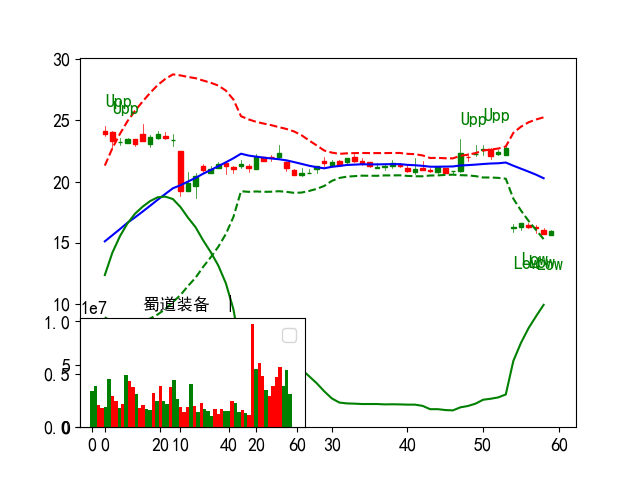

In [88]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [89]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_mask250.loc[cross_hmax_250].query('couts > 1 and perc > 0'))
# show_tdx_data(df_mask250.query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.loc[code_t])

(902, 32)

count dd.couts
(code    date      
002207  2025-06-16    5
        2025-06-17    5
        2025-06-18    5
Name: couts, dtype: int64, (750, 33))
compute percent
df_mask250:515 df_mask_hmax:190
cross_hamx:130
Count:11 41


name  couts       date   perc  ra_diff  xratio    idx  hat  close  \
code                                                                        
301176  逸豪新材      2 2025-06-23  20.00      0.0    0.32  11.73  0.0  29.28   
600113  浙江东日      4 2025-06-23   9.28      0.0    0.21   8.69  0.0  22.61   
301308   江波龙      2 2025-06-23   2.49      0.0    0.17   8.11  0.0  81.99   
601606  长城军工      3 2025-06-23  10.02      0.0    0.15   6.70  0.0  20.20   
300483  首华燃气      2 2025-06-23   1.08      0.0    0.18   5.45  0.0  15.01   
002207  准油股份      5 2025-06-23   5.51      0.0    0.17   4.00  0.0  10.15   
600367  红星发展      3 2025-06-23   3.24      0.0    0.10   3.21  0.0  16.56   
002805  丰元股份      2 2025-06-23   0.89      0.0    0.05   1.51  0.0  13.62   
002119  康强电子      3 2025-06-23   0.90      0.0    0.06   1.45  0.0  16.77   
002983   芯瑞达      2 2025-06-23   1.68      0.0    0.03   1.20  0.0  21.17   
603867  新化股份      2 2025-06-23   2.35      0.0    0.04   1.06  0.0  25.70   

        volsum5d  ...  ma250     nclose   llow  vol1d   vol2d   vol3d   vol4d  \
code              ...                                                           
301176     639.6  ...    0.0  27.354211  23.08 -100.0   37.66   45.04  689.69   
600113     207.5  ...    0.0  22.288761  20.10 -100.0  -12.22   86.66   43.46   
301308     165.5  ...    0.0  81.726228  79.26 -100.0    4.24  -30.74   24.66   
601606      73.0  ...    0.0  19.974425  18.92 -100.0  -17.43  125.62   32.60   
300483     -34.6  ...    0.0  15.407826  14.90 -100.0   53.94   37.77  -23.25   
002207    2127.3  ...    0.0  10.281062  10.01 -100.0  220.61  918.39  -94.83   
600367     -90.4  ...    0.0  16.391947  15.88 -100.0    0.45   21.11   31.28   
002805     355.3  ...    0.0  13.632566  12.91 -100.0  209.89  271.19   -9.09   
002119      20.2  ...    0.0  16.728684  16.02 -100.0   11.38  -18.88   16.90   
002983     222.5  ...    0.0  21.208772  20.34 -100.0   34.51  250.67   65.24   
603867      70.6  ...    0.0  25.761560  24.83 -100.0  189.50  -27.27   10.41   

          vol5d  perc3d  perc5d  
code                             
301176   -32.77   37.92   63.48  
600113   189.63   29.64   57.01  
301308   267.37    2.09   14.48  
601606    32.22   33.16   49.63  
300483    -3.11   34.62   37.71  
002207  1183.12   11.05   33.55  
600367   -43.25    9.02    9.67  
002805   -16.72   14.84   14.45  
002119   110.83    0.12    6.82  
002983   -27.94    5.96    8.07  
603867    -2.03    6.33    2.43  

[11 rows x 24 columns]

df_mask250:55
300875 0.0
xratio:0.24 ra_diff:nan
code: 300875


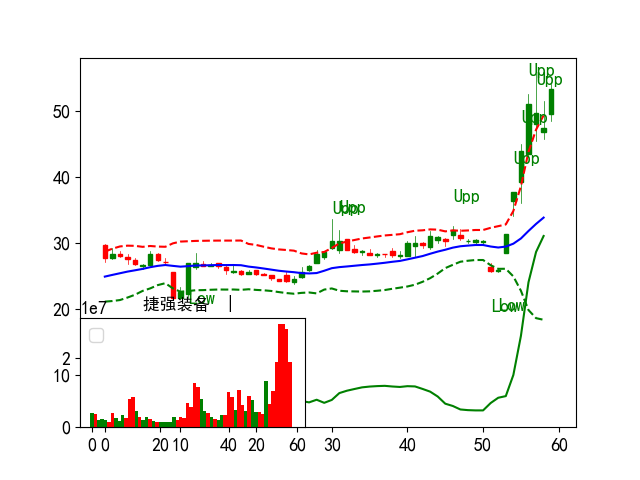

300468 0.0
xratio:0.3 ra_diff:nan
code: 300468


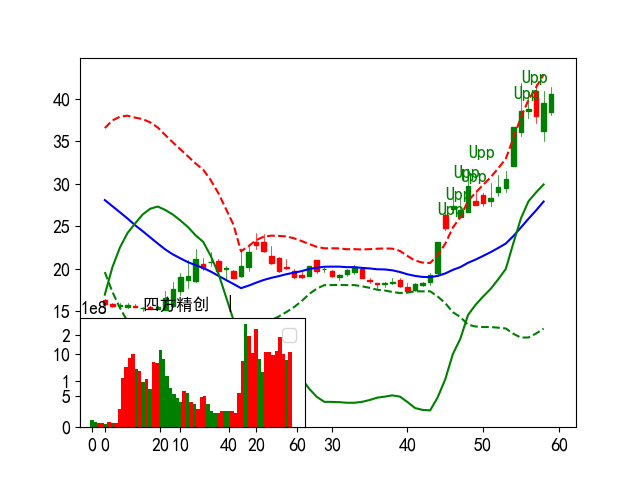

301176 0.0
xratio:0.27 ra_diff:nan
code: 301176


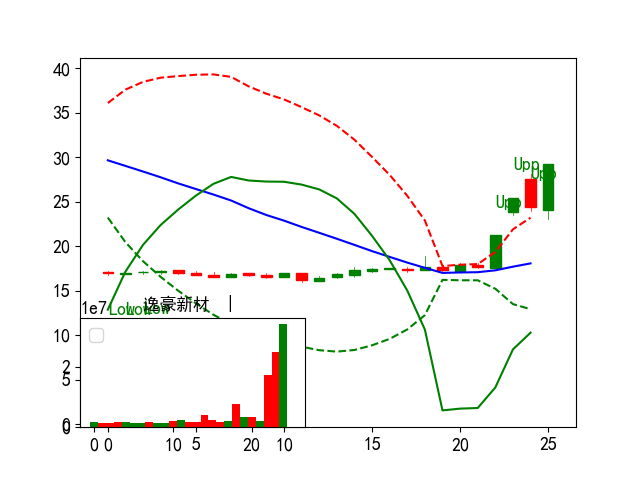

300548 0.0
xratio:0.5 ra_diff:nan
code: 300548


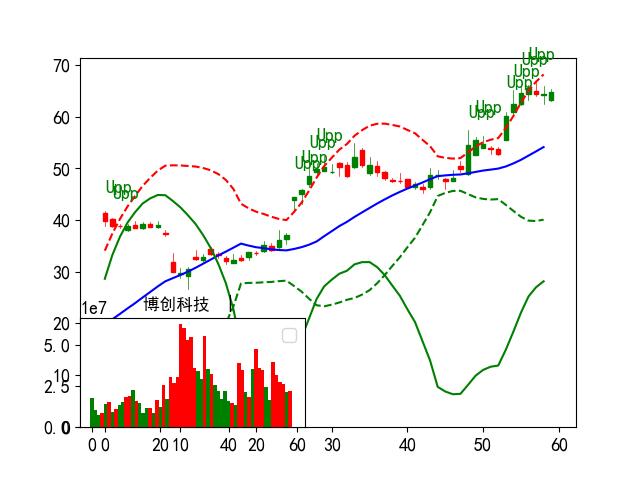

600113 0.0
xratio:0.05 ra_diff:nan
code: 600113


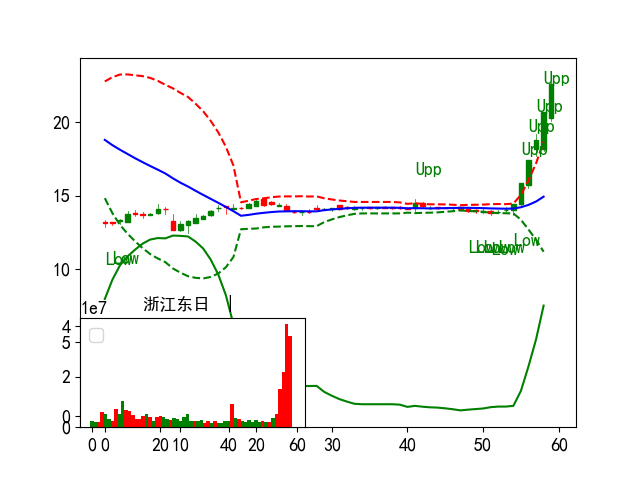

603585 0.0
xratio:0.09 ra_diff:nan
code: 603585


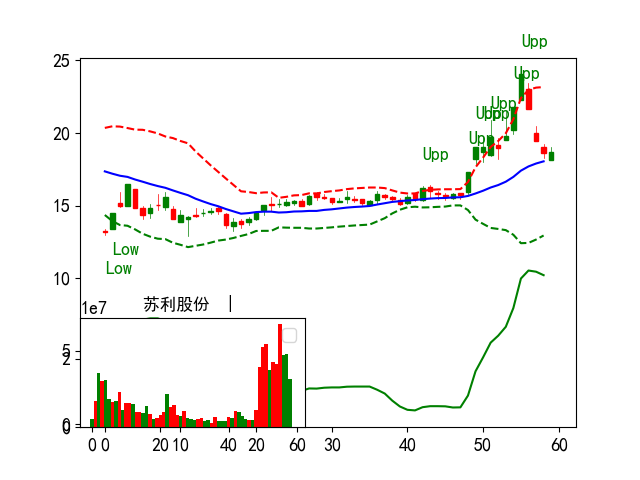

301308 0.0
xratio:-0.29 ra_diff:nan
code: 301308


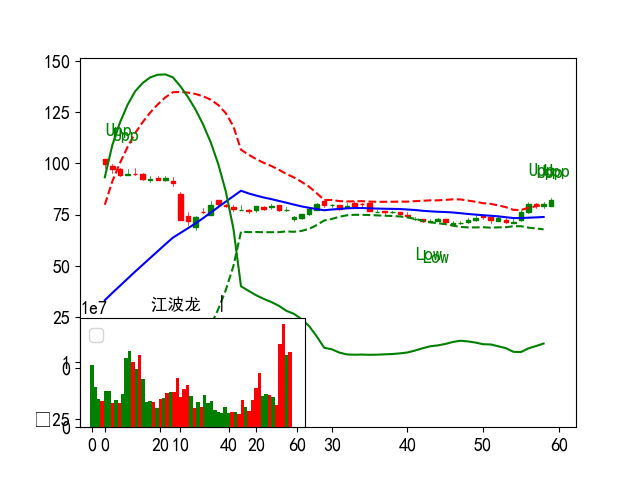

301155 0.0
xratio:0.13 ra_diff:nan
code: 301155


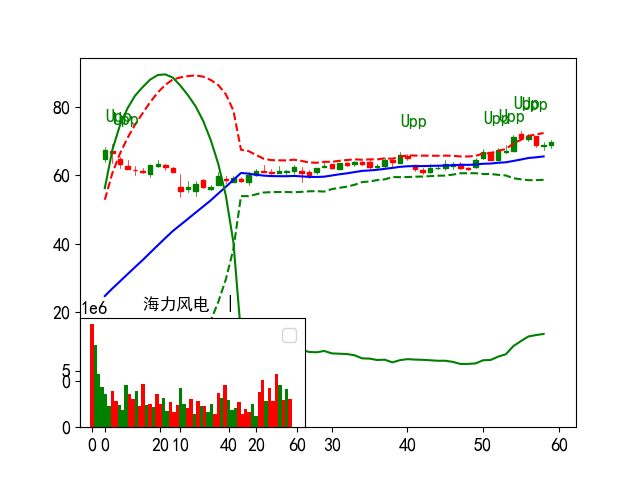

300773 0.0
xratio:0.17 ra_diff:nan
code: 300773


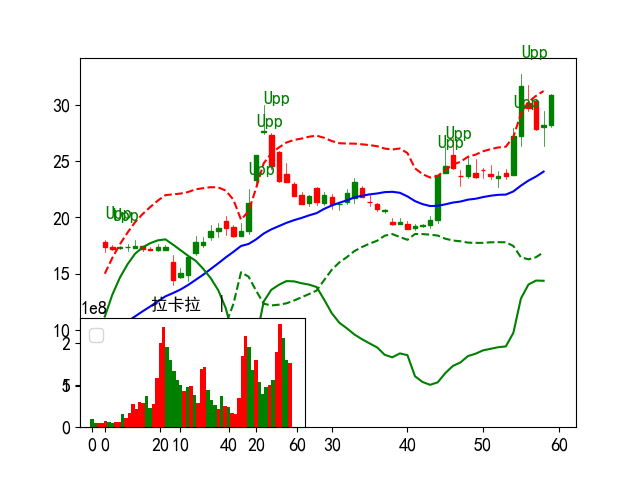

601606 0.0
xratio:0.06 ra_diff:nan
code: 601606


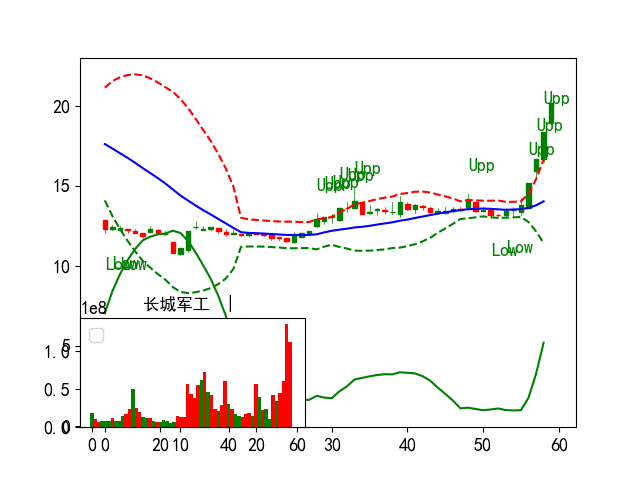

In [90]:
print("df_mask250:%s"%(len(df_mask250.query('couts > 1 and perc > 0'))))
for co in df_mask250.query('couts > 1 and perc > 0').index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [91]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date   lopen   lhigh    llow   close         vol        amount  \
code                                                                          
300308 2025-06-16  116.88  123.38  116.88  127.88  59369856.0  7.204022e+09   
001309 2025-06-18  126.25  136.00  125.75  125.23   8822176.0  1.153802e+09   

        ra_diff    ma10     ma5  ...  xratio    idx  couts      nclose   open  \
code                             ...                                            
300308     1.68  105.05  112.31  ...    0.75  27.06      1  128.080957  127.3   
001309     1.28  121.46  124.29  ...    0.24  21.31      1  125.178214  122.0   

          high     low  llastp            ticktime  perc  
code                                                      
300308  129.33  126.50  129.50 2025-06-23 10:13:03 -1.25  
001309  126.59  121.52  124.25 2025-06-23 10:13:06  0.79  

[2 rows x 41 columns]

(104, 41)

In [92]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(515, 41)  lastd:(137, 41) 
code
835579    机科股份
872351    华光源海
835174    五新隧装
301292    海科新源
301176    逸豪新材
601606    长城军工
002579    中京电子
600113    浙江东日
300589    江龙船艇
833346    威贸电子
301421    波长光电
300801    泰和科技
600110    诺德股份
300429    强力新材
301379    天山电子
300410    正业科技
603209    兴通股份
301132    满坤科技
603948    建业股份
603155     新亚强
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:190
002940 0.0
xratio:0.23 ra_diff:nan
code: 002940


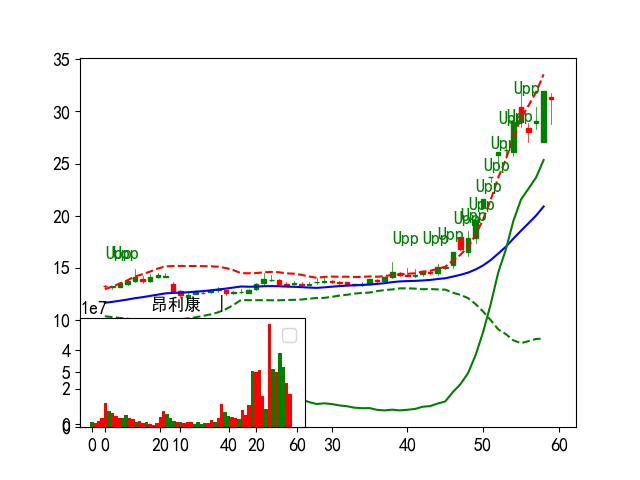

003040 0.0
xratio:0.11 ra_diff:nan
code: 003040


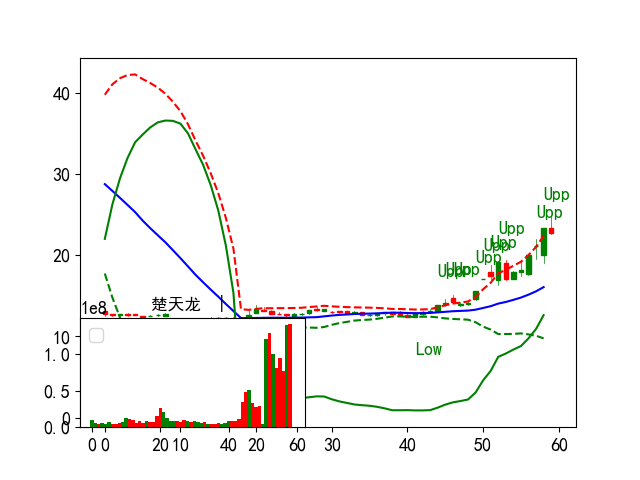

300308 0.0
xratio:0.5 ra_diff:nan
code: 300308


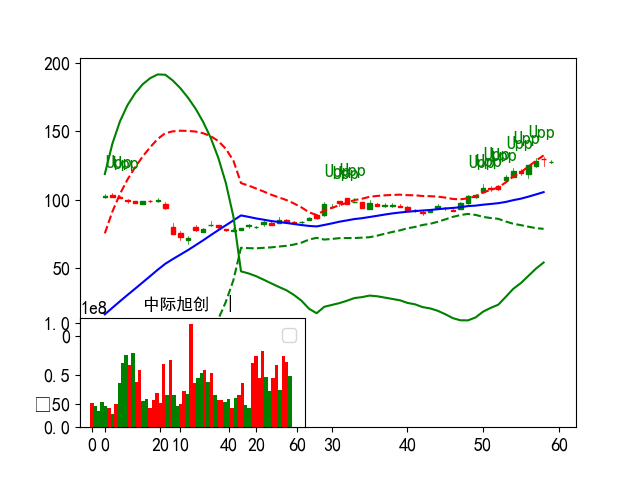

600000 0.0
xratio:0.05 ra_diff:nan
code: 600000


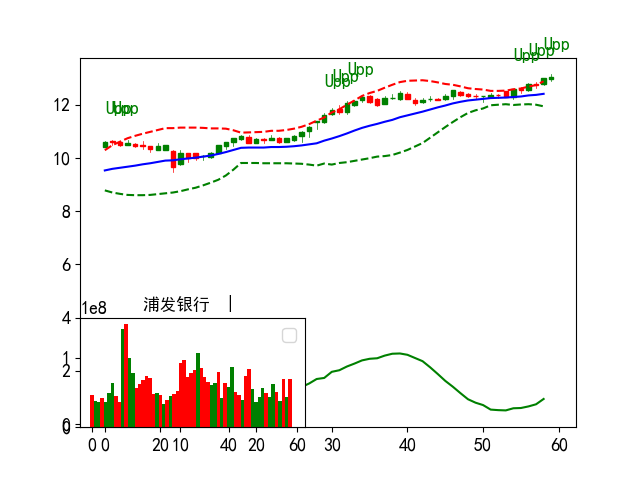

600919 0.0
xratio:0.04 ra_diff:nan
code: 600919


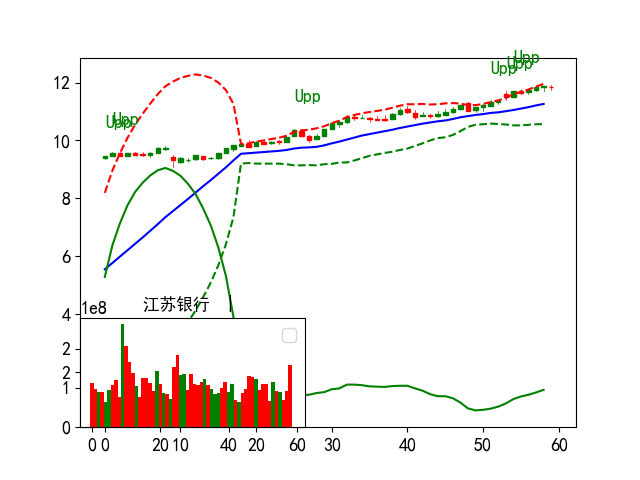

601169 0.0
xratio:0.01 ra_diff:nan
code: 601169


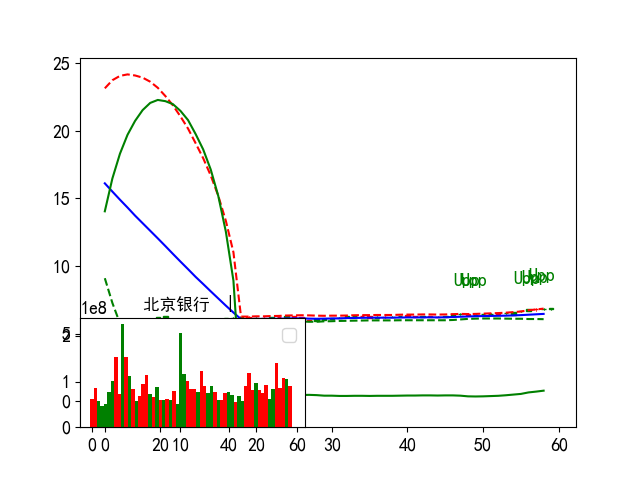

300340 0.0
xratio:0.12 ra_diff:nan
code: 300340


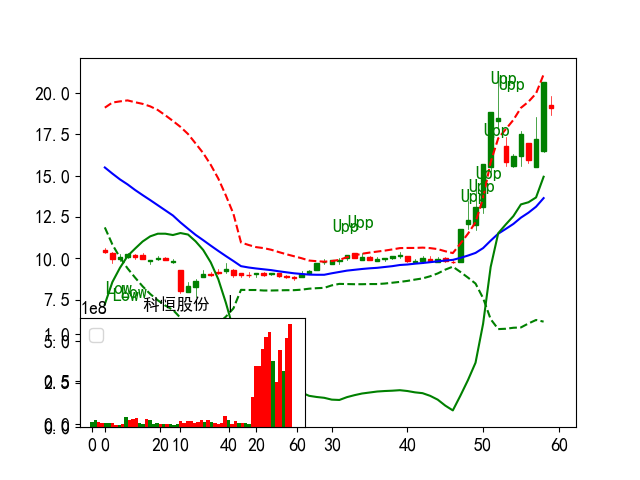

603306 0.0
xratio:0.08 ra_diff:nan
code: 603306


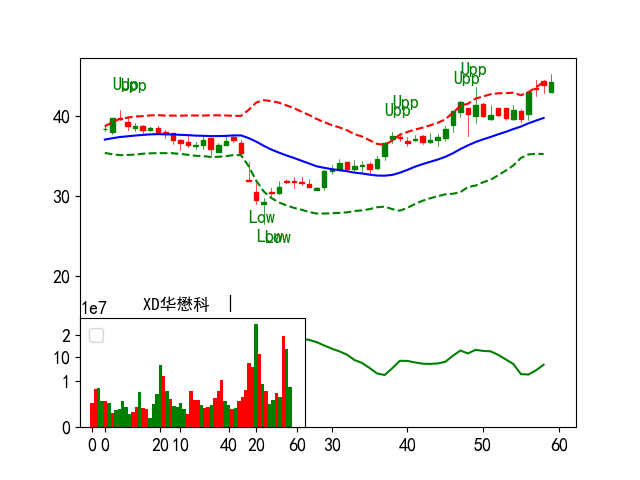

002235 0.0
xratio:0.04 ra_diff:nan
code: 002235


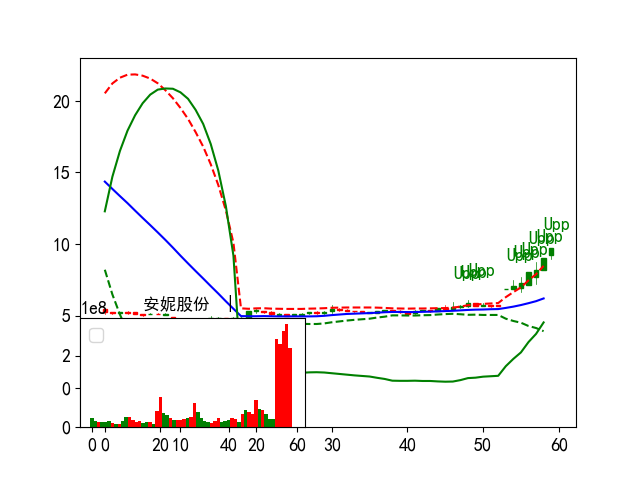

002207 0.0
xratio:0.04 ra_diff:nan
code: 002207


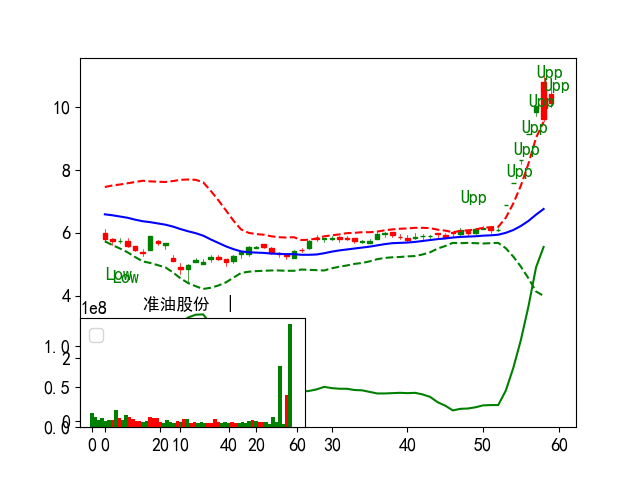

In [93]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:137
835579 0.0
xratio:nan ra_diff:nan
code: 835579


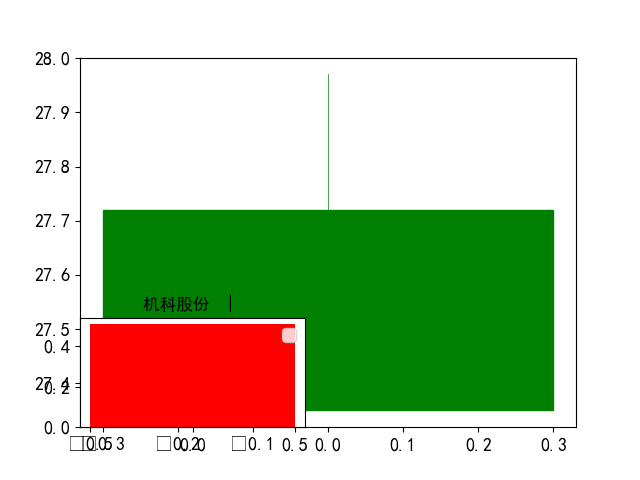

872351 0.0
xratio:nan ra_diff:nan
code: 872351


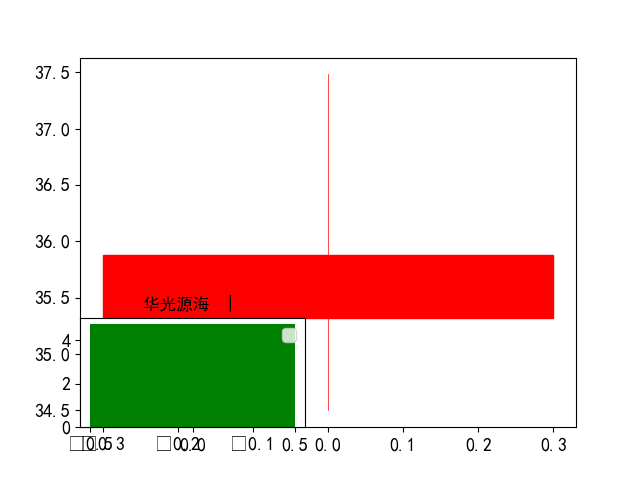

835174 0.0
xratio:nan ra_diff:nan
code: 835174


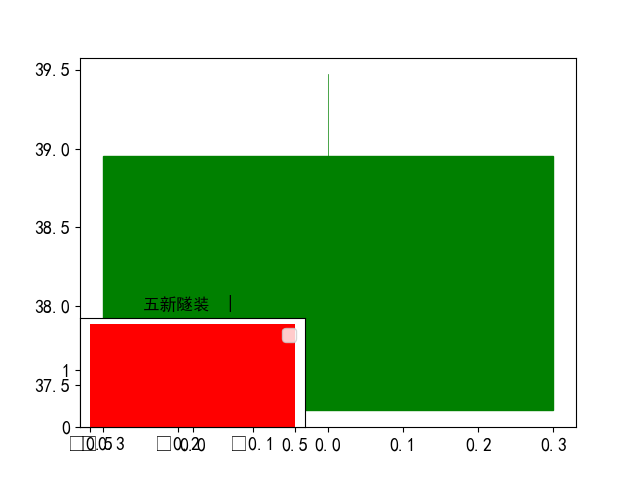

301292 0.0
xratio:0.21 ra_diff:nan
code: 301292


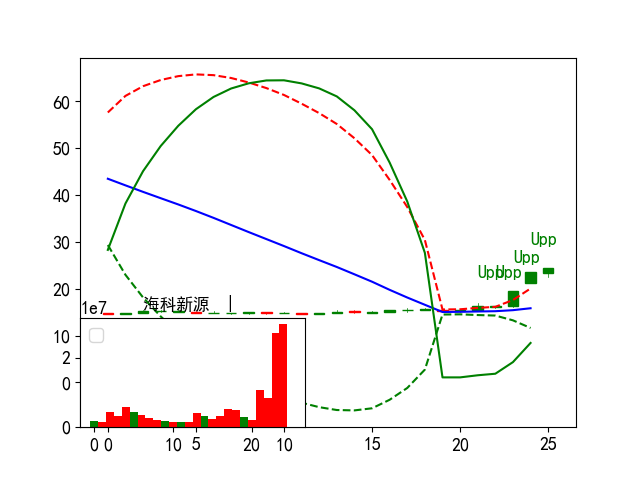

301176 0.0
xratio:0.27 ra_diff:nan
code: 301176


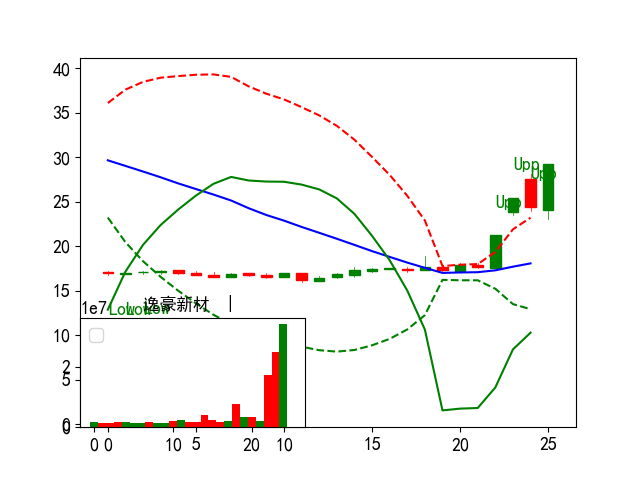

601606 0.0
xratio:0.06 ra_diff:nan
code: 601606


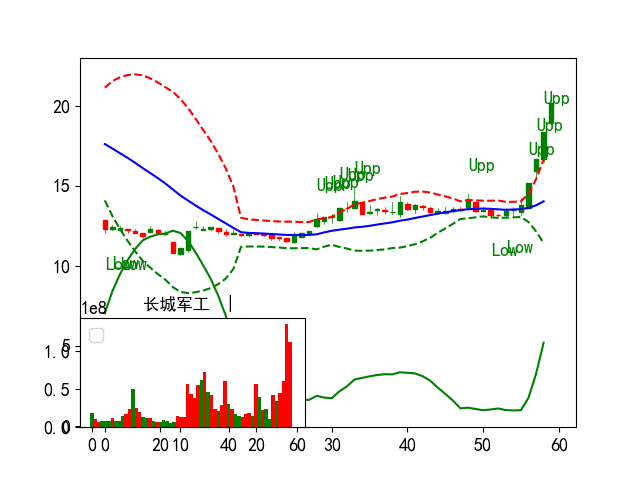

002579 0.0
xratio:0.02 ra_diff:nan
code: 002579


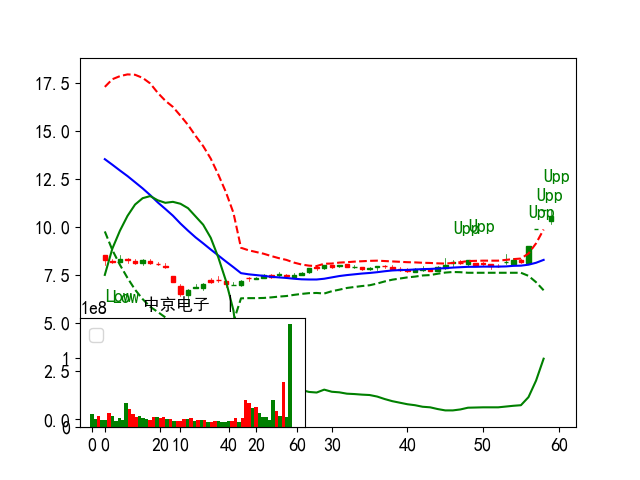

600113 0.0
xratio:0.05 ra_diff:nan
code: 600113


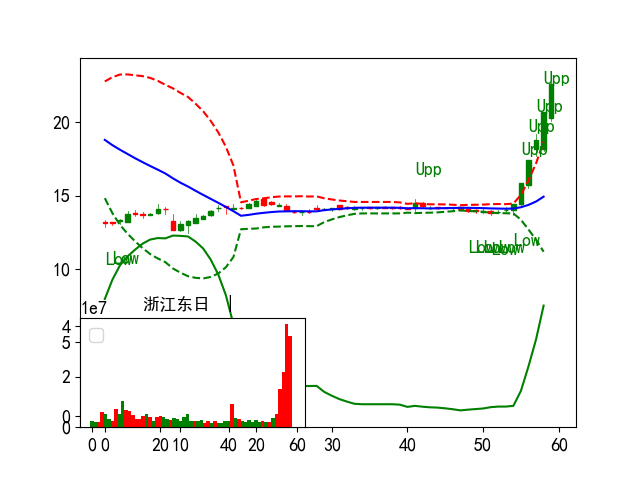

300589 0.0
xratio:-0.01 ra_diff:nan
code: 300589


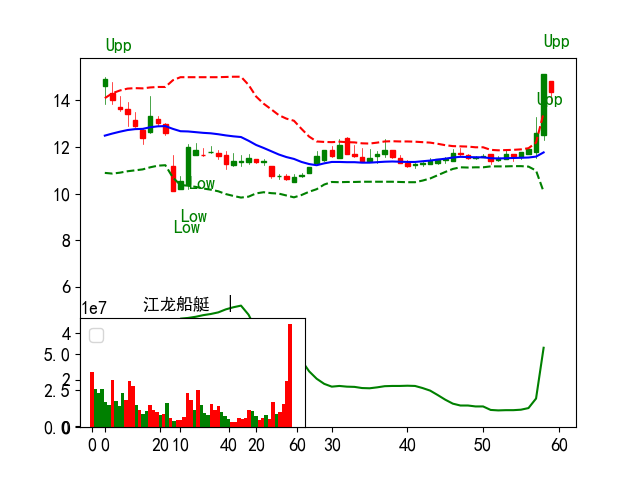

833346 0.0
xratio:nan ra_diff:nan
code: 833346


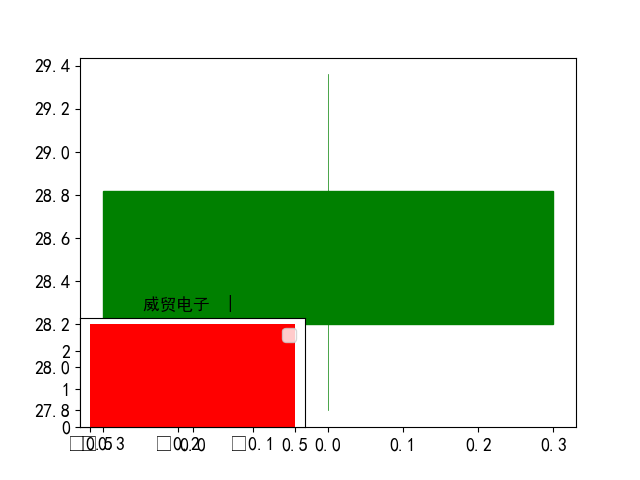

In [94]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [95]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250],limit=5)

cross_hamx:72
Count:72 41


name  couts       date   perc  ra_diff  xratio    idx  hat  close  \
code                                                                        
835579  机科股份      1 2025-06-23  -0.57      0.0    0.00   0.00  0.0  27.72   
872351  华光源海      1 2025-06-23   8.34      0.0    0.00   0.00  0.0  35.32   
835174  五新隧装      1 2025-06-23   2.64      0.0    0.00   0.00  0.0  38.95   
301292  海科新源      1 2025-06-23   4.12      0.0    0.24   9.05  0.0  24.49   
301176  逸豪新材      2 2025-06-23  20.00      0.0    0.32  11.73  0.0  29.28   

        volsum5d  ...  ma250     nclose   llow   vol1d   vol2d   vol3d  \
code              ...                                                    
835579      92.7  ...    0.0  27.738667  27.35  -55.65  238.24  -34.62   
872351    1006.0  ...    0.0  35.433486  34.50  800.00   39.47  -84.68   
835174     635.7  ...    0.0  38.718679  37.34   -5.24  664.00  -86.49   
301292     564.0  ...    0.0  23.704649  22.56 -100.00    9.57  228.12   
301176     639.6  ...    0.0  27.354211  23.08 -100.00   37.66   45.04   

         vol4d   vol5d  perc3d  perc5d  
code                                    
835579   23.81  -79.10  314.97  186.36  
872351  320.34  -69.11  120.75  -20.54  
835174   24.16   39.25   83.47   70.38  
301292  -21.57  447.84   49.97   59.03  
301176  689.69  -32.77   37.92   63.48  

[5 rows x 24 columns]

df_mask250:72
002270 0.0
xratio:0.03 ra_diff:nan
code: 002270


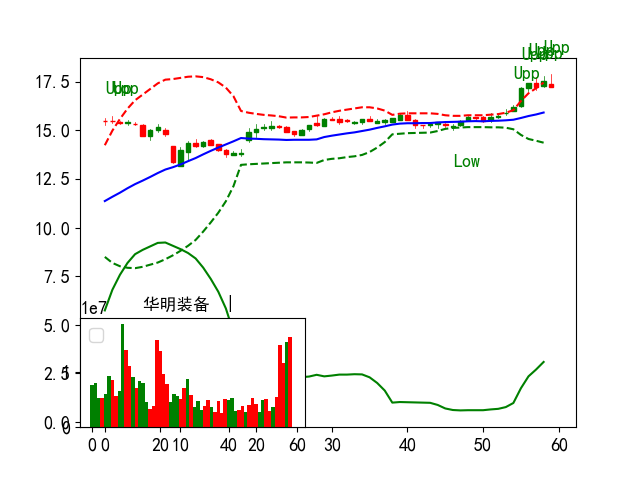

301308 0.0
xratio:-0.29 ra_diff:nan
code: 301308


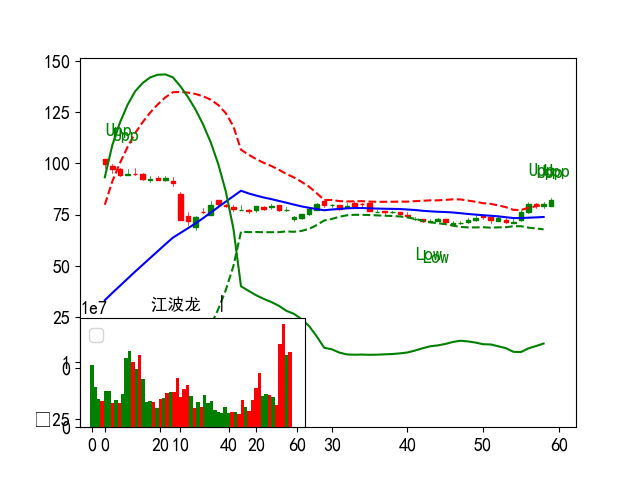

301516 0.0
xratio:0.02 ra_diff:nan
code: 301516


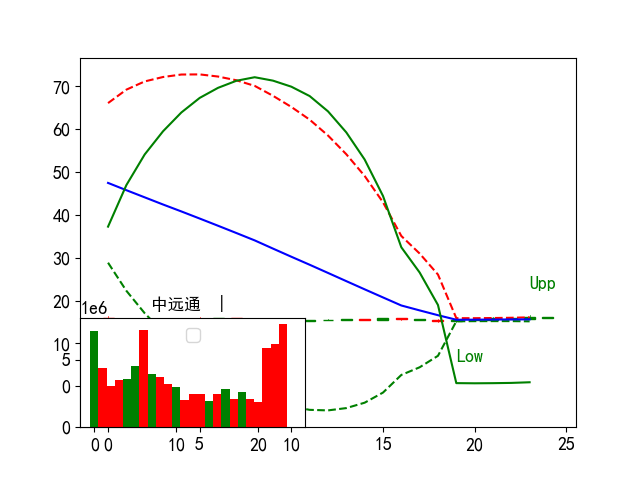

600195 0.0
xratio:0.01 ra_diff:nan
code: 600195


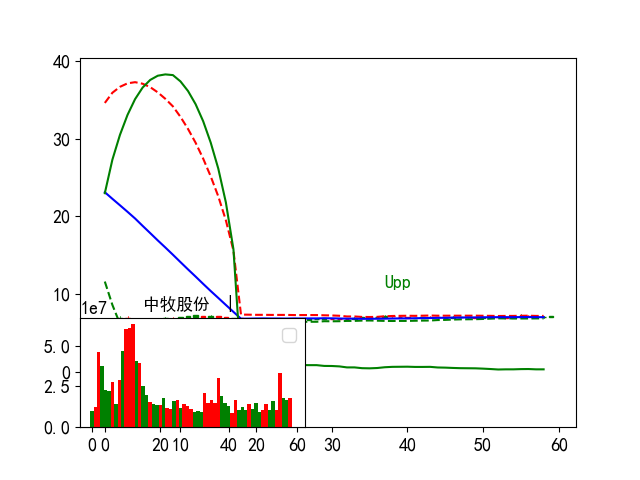

300568 0.0
xratio:0.01 ra_diff:nan
code: 300568


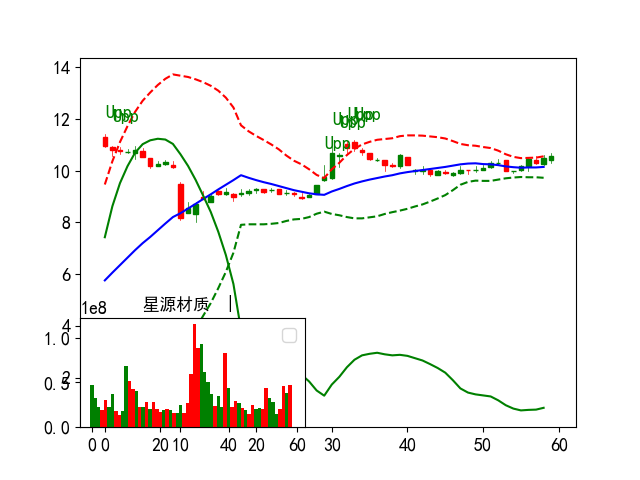

300080 0.0
xratio:0.01 ra_diff:nan
code: 300080


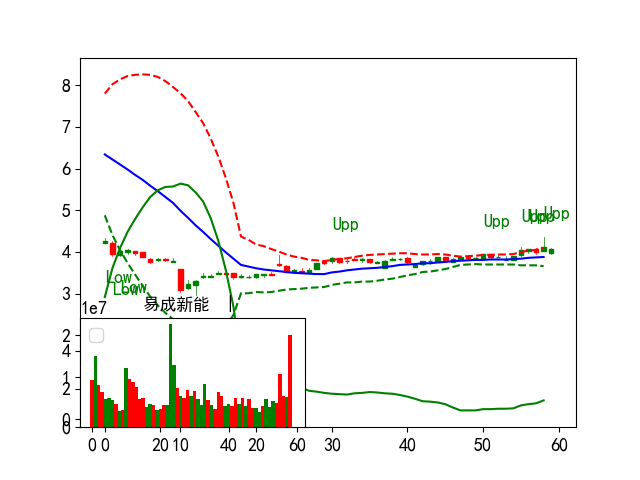

002119 0.0
xratio:-0.0 ra_diff:nan
code: 002119


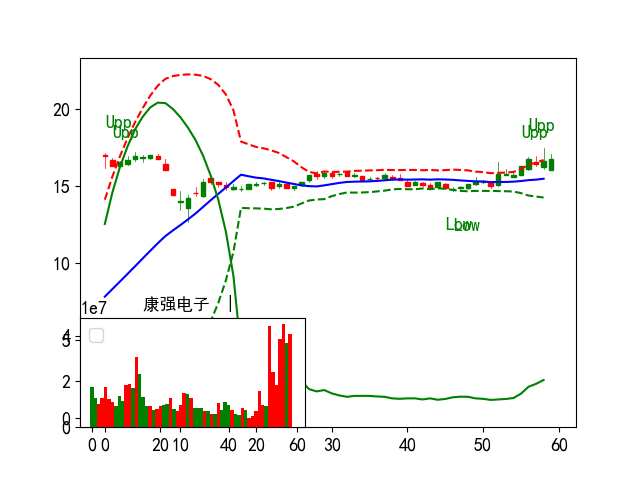

835207 0.0
xratio:nan ra_diff:nan
code: 835207


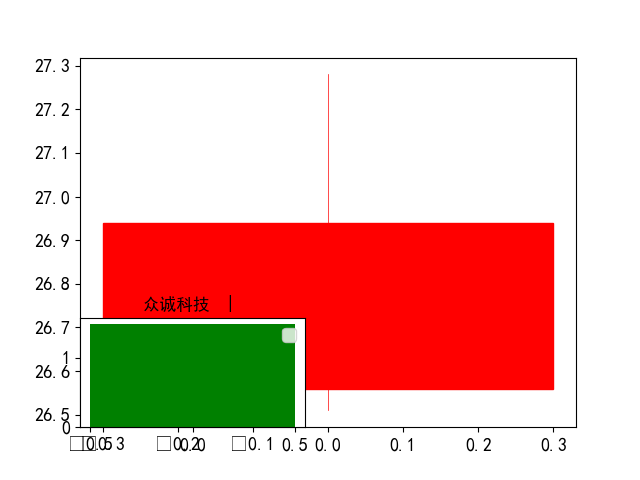

300708 0.0
xratio:-0.0 ra_diff:nan
code: 300708


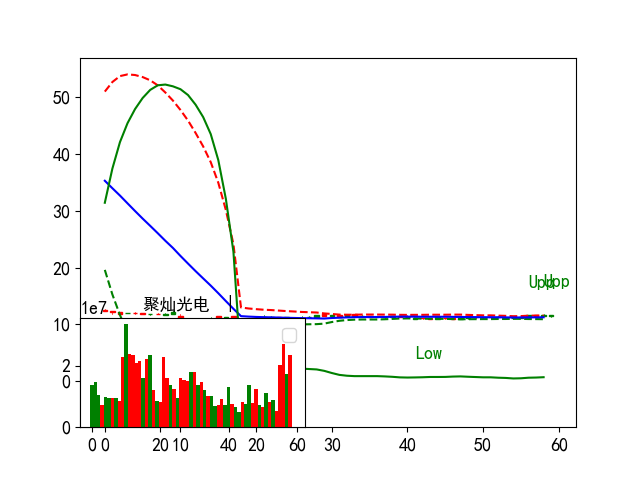

833429 0.0
xratio:nan ra_diff:nan
code: 833429


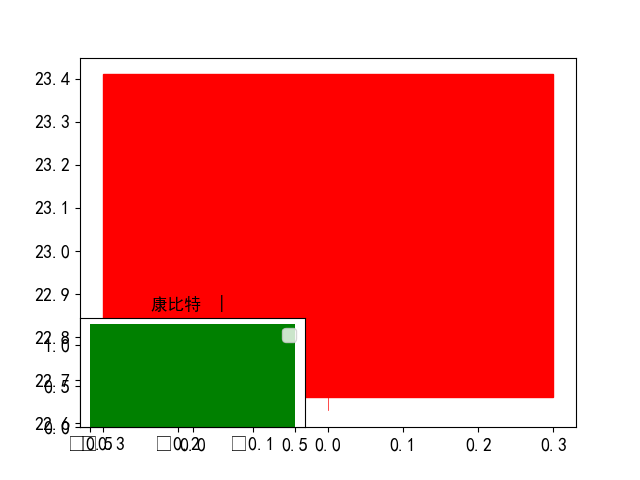

In [96]:
print("df_mask250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [97]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [98]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [99]:
top_temp.shape
top_temp.index

(216, 34)

Index(['688668', '603373', '601009', '301369', '301345', '300476', '002352',
       '300804', '601838', '601808',
       ...
       '300263', '600113', '300505', '603800', '688291', '300056', '002826',
       '002017', '300502', '688502'],
      dtype='object', name='code', length=216)

## plt.close('all')

In [100]:
# plt.close('all')

# 写入060